In [1]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import time
import warnings
import gc
import random

# Statistical utilities
from scipy.stats import ks_2samp

# Minimal model support for streaming detectors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# River drift detectors (streaming methods)
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# River datasets for benchmark generation (SEA, Hyperplane, etc.)
from river.datasets import synth

# Drift detection modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import shape, shape_snr_adaptive
from d3 import d3
from dawidd import dawidd
from gen_data import gen_random
from mmd import mmd
from ow_mmd import mmd_ow, shapedd_ow_mmd, shapedd_ow_mmd_buffer
from ks import ks

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')


In [2]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Visualization settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 3000
RANDOM_SEED = random.randint(0, 1000000)

# Detection parameters (following run__drift_detection.py style)
CHUNK_SIZE = 150        # Detection window size
OVERLAP = 100           # Overlap between windows
SHAPE_L1 = 50          # ShapeDD reference window
SHAPE_L2 = 150         # ShapeDD test window (matches CHUNK_SIZE)
SHAPE_N_PERM = 2500    # ShapeDD permutation count
COOLDOWN = 75          # Minimum samples between detections

# SPECTRA-DRIFT parameters
SPECTRA_WINDOW = 500         # Window size for spectral analysis
SPECTRA_K = None             # Number of neighbors (None = auto sqrt(window_size))
SPECTRA_EIGENVALUES = 10  # Number of eigenvalues to extract
SPECTRA_ALPHA = 0.01         # False positive rate (auto-calibrated threshold)

# Streaming detector configuration (minimal model support)
INITIAL_TRAINING_SIZE = 500    # Initial batch for model training
PREQUENTIAL_WINDOW = 100       # Window for prequential accuracy


# Window-based methods
WINDOW_METHODS = [
    'D3',           # Margin density drift detector
    'DAWIDD',       # Distance-aware windowed drift detector
    'MMD',          # Maximum Mean Discrepancy
    'KS',           # Kolmogorov-Smirnov test
    'ShapeDD',      # Original method
    'ShapeDD_SNR_Adaptive', # SNR-Aware Hybrid
    'MMD_OW',       # Optimally-Weighted MMD estimator                  
    'ShapeDD_OW_MMD', # ShapeDD + OW-MMD Hybrid
]

# Streaming methods
STREAMING_METHODS = [
    # 'ADWIN',        # Adaptive Windowing
    # 'DDM',          # Drift Detection Method
    # 'EDDM',         # Early Drift Detection Method
    # 'HDDM_A',       # Hoeffding's Drift Detection Method (Average)
    # 'HDDM_W',       # Hoeffding's Drift Detection Method (Weighted)
    # 'FHDDM'         # Fast Hoeffding Drift Detection Method
]


DATASET_CATALOG = {
    # ========================================================================
    # SUDDEN DRIFT DATASETS (8 datasets)
    # Classic benchmarks with abrupt concept switches
    # ========================================================================
    "standard_sea": {
        "enabled": True,
        "type": "standard_sea",
        "n_drift_events": 10,
        "params": {}
    },
    "enhanced_sea": {
        "enabled": False,
        "type": "enhanced_sea",
        "n_drift_events": 10,
        "params": {
            "scale_factors": (1.8, 1.5, 2.0),
            "shift_amounts": (5.0, 4.0, 8.0)
        }
    },
    "stagger": {
        "enabled": True,
        "type": "stagger",
        "n_drift_events": 10,
        "params": {}
    },
    "hyperplane": {
        "enabled": True,
        "type": "hyperplane",
        "n_drift_events": 10,
        "params": {
            "n_features": 3
        }
    },
    "gen_random_mild": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 0.125,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_moderate": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 0.25,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_severe": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 1,
            "dist": "unif",
            "alt": True
        }
    },
    "gen_random_ultra_severe": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 2,
            "dist": "unif",
            "alt": True
        }
    },
    
    # ========================================================================
    # GRADUAL DRIFT DATASETS (4 datasets)
    # Smooth blending transitions between concepts
    # ========================================================================
    
    "sea_gradual": {
        "enabled": False,
        "type": "sea_gradual",
        "n_drift_events": 10,
        "params": {
            "transition_width": 450  # OPTIMIZED: 50% of segment (909 samples)
        }
    },
    "hyperplane_gradual": {
        "enabled": False,
        "type": "hyperplane_gradual",
        "n_drift_events": 10,
        "params": {
            "n_features": 10  # Continuous drift (no discrete transition)
        }
    },
    "agrawal_gradual": {
        "enabled": False,
        "type": "agrawal_gradual",
        "n_drift_events": 10,
        "params": {
            "transition_width": 450  # OPTIMIZED: 50% of segment (909 samples)
        }
    },
    "circles_gradual": {
        "enabled": False,
        "type": "circles_gradual",
        "n_drift_events": 10,
        "params": {
            "transition_width": 400  # OPTIMIZED: 44% of segment (more stable)
        }
    },
    
    # ========================================================================
    # INCREMENTAL DRIFT DATASETS (2 datasets) - MOA Standard
    # Continuous cluster boundary movement
    # ========================================================================
    
    "rbf_slow": {
        "enabled": False,
        "type": "rbf",
        "n_drift_events": 10,
        "params": {
            "n_centroids": 50,    # MOA standard
            "speed": 0.0001       # Slow continuous drift
        }
    },
    "rbf_fast": {
        "enabled": False,
        "type": "rbf",
        "n_drift_events": 10,
        "params": {
            "n_centroids": 50,    # MOA standard
            "speed": 0.001        # Fast continuous drift (10× faster)
        }
    },
    
    # ========================================================================
    # REAL-WORLD DATASETS (1 dataset)
    # Natural concept drift from real-world processes
    # NO GROUND TRUTH - Use for qualitative analysis only
    # ========================================================================
    
    "electricity": {
        "enabled": False,
        "type": "electricity",
        "n_drift_events": 5,      # Estimated (no ground truth available)
        "params": {}
    },
    
    # ========================================================================
    # STATIONARY DATASETS (2 datasets) - False Positive Analysis
    # No drift - for statistical calibration validation
    # ========================================================================
    
    "stagger_none": {
        "enabled": False,
        "type": "stagger",
        "n_drift_events": 0,      # NO DRIFT - stationary
        "params": {}
    },
    "gen_random_none": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 0,      # NO DRIFT - stationary
        "params": {
            "dims": 5,
            "intens": 0,          # Zero intensity = no drift
            "dist": "unif",
            "alt": False
        }
    },
    
    # ========================================================================
    # SINE FAMILY: Classification Reversal + Noise Robustness Tests
    # ========================================================================
    "sine1": {
        "enabled": False,
        "type": "sine1",
        "n_drift_events": 10,
        "params": {}
    },
    "sine2": {
        "enabled": False,
        "type": "sine2",
        "n_drift_events": 10,
        "params": {}
    },
    "sinirrel1": {
        "enabled": False,
        "type": "sinirrel1",
        "n_drift_events": 10,
        "params": {}
    },
    "sinirrel2": {
        "enabled": False,
        "type": "sinirrel2",
        "n_drift_events": 10,
        "params": {}
    },

    # ========================================================================
    # RBF AND LED: Complex Distributions
    # ========================================================================
    "rbfblips": {
        "enabled": False,
        "type": "rbfblips",
        "n_drift_events": 10,
        "params": {
            "n_centroids": 50,
            "n_features": 10
        }
    },
    "led_abrupt": {
        "enabled": True,
        "type": "led_abrupt",
        "n_drift_events": 10,
        "params": {
            "has_noise": False
        }
    },


}

enabled_datasets = [k for k, v in DATASET_CATALOG.items() if v['enabled']]
sudden_datasets = [k for k in enabled_datasets if 'gradual' not in k and 'rbf' not in k and 'electricity' not in k and 'none' not in k]
gradual_datasets = [k for k in enabled_datasets if 'gradual' in k]
incremental_datasets = [k for k in enabled_datasets if 'rbf' in k]
realworld_datasets = [k for k in enabled_datasets if 'electricity' in k]
stationary_datasets = [k for k in enabled_datasets if 'none' in k]


In [3]:
# ============================================================================
# SECTION 3: DATASET GENERATION (Multiple Benchmark Datasets)
# ============================================================================

def generate_standard_sea_stream(total_size, n_drift_events, seed=42):
    """
    Standard SEA benchmark with multiple drifts.
    Creates sudden drifts by switching between SEA variants.
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]  # SEA has 4 variants
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_enhanced_sea_stream(total_size, n_drift_events, seed=42,
                                  scale_factors=(1.8, 1.5, 2.0),
                                  shift_amounts=(5.0, 4.0, 8.0)):
    """Enhanced SEA with multiple drifts and transformations."""
    np.random.seed(seed)

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)

        for i, (x, y) in enumerate(stream.take(size)):
            x_vals = list(x.values())

            # Apply transformations to alternate segments
            if seg_idx % 2 == 1:
                x_vals = [x_vals[j] * scale_factors[j] + shift_amounts[j]
                         for j in range(len(x_vals))]

            X_list.append(x_vals)
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_stagger_stream(total_size, n_drift_events, seed=42):
    """STAGGER concepts with multiple sudden drifts."""
    np.random.seed(seed)

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    X_segments, y_segments = [], []

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        X_seg = np.random.randn(size, 5)

        # Different concepts for each segment
        if seg_idx % 3 == 0:
            X_seg[:, 0] += 2.0
            y_seg = (X_seg[:, 0] + X_seg[:, 1] > 1.5).astype(int)
        elif seg_idx % 3 == 1:
            X_seg[:, 0] -= 2.0
            y_seg = (X_seg[:, 0] * X_seg[:, 1] > 0).astype(int)
        else:
            X_seg[:, 1] += 1.5
            y_seg = (X_seg[:, 1] + X_seg[:, 2] > 0.5).astype(int)

        X_segments.append(X_seg)
        y_segments.append(y_seg)

    X = np.vstack(X_segments)
    y = np.hstack(y_segments)

    return X, y, drift_positions


def generate_hyperplane_stream(total_size, n_drift_events, seed=42, n_features=10):
    """Rotating Hyperplane with multiple drifts."""
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    mag_changes = [0.0001, 0.01, 0.005, 0.015]  # Alternate rotation speeds

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        mag_change = mag_changes[seg_idx % len(mag_changes)]

        stream = synth.Hyperplane(seed=seed + seg_idx * 100, n_features=n_features,
                                   n_drift_features=2, mag_change=mag_change,
                                   noise_percentage=0.05)

        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_genrandom_stream(total_size, n_drift_events, seed=42,
                               dims=5, intens=0.125, dist="unif", alt=False):
    """Custom synthetic data using gen_random with multiple drifts."""
    np.random.seed(seed)

    X, y_drift_labels = gen_random(
        number=n_drift_events,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size
    )

    # Find actual drift positions
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    drift_positions = drift_indices.tolist()

    # Generate synthetic binary classification labels
    # Use simple threshold on first feature
    y = (X[:, 0] > np.median(X[:, 0])).astype(int)

    return X, y, drift_positions


# ============================================================================
# GRADUAL DRIFT DATASET GENERATORS
# ============================================================================

def generate_sea_gradual_stream(total_size, n_drift_events, seed=42, transition_width=1000):
    """
    SEA benchmark with GRADUAL drifts (smooth transitions between variants).
    
    Instead of instant variant switches, blends samples from old→new concept
    over transition_width samples.
    
    Args:
        transition_width: Number of samples for gradual transition (default: 1000)
                         During transition, samples are blended: 
                         Start: 100% old, 0% new → End: 0% old, 100% new
    """
    np.random.seed(seed)

    X_list, y_list = [], []
    variants = [0, 1, 2, 3]

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Generate segments with gradual transitions
    for seg_idx in range(n_drift_events + 1):
        old_variant = variants[seg_idx % len(variants)]
        new_variant = variants[(seg_idx + 1) % len(variants)]
        
        if seg_idx == 0:
            # First segment - no transition at start
            stream = synth.SEA(seed=seed + seg_idx * 100, variant=old_variant)
            for i, (x, y) in enumerate(stream.take(segment_size)):
                X_list.append(list(x.values()))
                y_list.append(y)
        else:
            # Gradual transition segment
            transition_start = len(X_list)
            
            # Generate samples from both concepts
            stream_old = synth.SEA(seed=seed + seg_idx * 100, variant=old_variant)
            stream_new = synth.SEA(seed=seed + (seg_idx + 1) * 100, variant=new_variant)
            
            samples_old = list(stream_old.take(segment_size))
            samples_new = list(stream_new.take(segment_size))
            
            for i in range(segment_size):
                # Calculate blend ratio (linear interpolation)
                if i < transition_width:
                    # Gradual transition: old → new
                    alpha = i / transition_width  # 0 → 1
                    
                    x_old = np.array(list(samples_old[i][0].values()))
                    x_new = np.array(list(samples_new[i][0].values()))
                    y_old = samples_old[i][1]
                    y_new = samples_new[i][1]
                    
                    # Blend features
                    x_blended = (1 - alpha) * x_old + alpha * x_new
                    
                    # Blend labels probabilistically
                    if np.random.rand() < alpha:
                        y_blended = y_new
                    else:
                        y_blended = y_old
                    
                    X_list.append(x_blended.tolist())
                    y_list.append(y_blended)
                else:
                    # After transition - pure new concept
                    X_list.append(list(samples_new[i][0].values()))
                    y_list.append(samples_new[i][1])

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_hyperplane_gradual_stream(total_size, n_drift_events, seed=42, n_features=10):
    """
    Rotating Hyperplane with CONTINUOUS gradual drift.
    
    Uses very small mag_change to create smooth, continuous rotation
    instead of sudden jumps between segments.
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    # Use VERY SMALL mag_change for gradual rotation
    # This creates continuous drift throughout the stream
    stream = synth.Hyperplane(
        seed=seed, 
        n_features=n_features,
        n_drift_features=5,  # More features drifting for observable change
        mag_change=0.0001,   # VERY small = gradual
        sigma=0.1,           # Small noise
        noise_percentage=0.05
    )

    # Generate full stream (drift happens continuously)
    for i, (x, y) in enumerate(stream.take(total_size)):
        X_list.append(list(x.values()))
        y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    # Estimate drift positions (evenly spaced)
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    return X, y, drift_positions


def generate_agrawal_gradual_stream(total_size, n_drift_events, seed=42, transition_width=1000):
    """
    Agrawal generator with GRADUAL transitions between classification functions.
    
    Agrawal has 10 different classification functions. We gradually blend
    between them over transition_width samples.
    """
    np.random.seed(seed)

    X_list, y_list = [], []
    
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Cycle through classification functions (0-9)
    for seg_idx in range(n_drift_events + 1):
        old_func = seg_idx % 10
        new_func = (seg_idx + 1) % 10
        
        if seg_idx == 0:
            # First segment - no transition
            stream = synth.Agrawal(seed=seed + seg_idx * 100, classification_function=old_func)
            for i, (x, y) in enumerate(stream.take(segment_size)):
                X_list.append(list(x.values()))
                y_list.append(y)
        else:
            # Gradual transition segment
            stream_old = synth.Agrawal(seed=seed + seg_idx * 100, classification_function=old_func)
            stream_new = synth.Agrawal(seed=seed + (seg_idx + 1) * 100, classification_function=new_func)
            
            samples_old = list(stream_old.take(segment_size))
            samples_new = list(stream_new.take(segment_size))
            
            for i in range(segment_size):
                if i < transition_width:
                    # Gradual transition via probabilistic label selection
                    alpha = i / transition_width
                    
                    # Use old sample's features but blend labels probabilistically
                    x_features = list(samples_old[i][0].values())
                    y_old = samples_old[i][1]
                    y_new = samples_new[i][1]
                    
                    # Blend labels probabilistically
                    if np.random.rand() < alpha:
                        y_blended = y_new
                    else:
                        y_blended = y_old
                    
                    X_list.append(x_features)
                    y_list.append(y_blended)
                else:
                    # Pure new concept
                    X_list.append(list(samples_new[i][0].values()))
                    y_list.append(samples_new[i][1])

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_circles_gradual_stream(total_size, n_drift_events, seed=42, transition_width=500):
    """
    Circles dataset with GRADUAL drifts (circles move/resize smoothly).
    
    Classic synthetic benchmark: 2D data with circular decision boundaries
    that gradually move and resize over transition windows.
    """
    np.random.seed(seed)
    
    X_list, y_list = [], []
    
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Define circle configurations (center_x, center_y, radius)
    circles = [
        (0.25, 0.25, 0.15),  # Circle 1
        (0.75, 0.25, 0.15),  # Circle 2
        (0.25, 0.75, 0.15),  # Circle 3
        (0.75, 0.75, 0.15),  # Circle 4
    ]
    
    for seg_idx in range(n_drift_events + 1):
        # Get current and next circle configuration
        old_circle = circles[seg_idx % len(circles)]
        new_circle = circles[(seg_idx + 1) % len(circles)]
        
        for i in range(segment_size):
            # Generate random point in [0, 1] × [0, 1]
            x = np.random.rand()
            y = np.random.rand()
            
            if seg_idx == 0 or i >= transition_width:
                # Use current circle (before transition or after transition complete)
                if seg_idx == 0:
                    cx, cy, r = old_circle
                else:
                    cx, cy, r = new_circle
            else:
                # Gradual transition - interpolate circle parameters
                alpha = i / transition_width
                
                cx = (1 - alpha) * old_circle[0] + alpha * new_circle[0]
                cy = (1 - alpha) * old_circle[1] + alpha * new_circle[1]
                r = (1 - alpha) * old_circle[2] + alpha * new_circle[2]
            
            # Classification: inside circle = class 1, outside = class 0
            distance = np.sqrt((x - cx)**2 + (y - cy)**2)
            label = 1 if distance <= r else 0
            
            X_list.append([x, y])
            y_list.append(label)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


# ============================================================================
# INCREMENTAL DRIFT DATASET GENERATORS (NEW - Following MOA/River Standards)
# ============================================================================

def generate_rbf_stream(total_size, n_drift_events, seed=42, n_centroids=50, speed=0.0001):
    """
    Random RBF with moving centroids (INCREMENTAL/CONTINUOUS drift).
    
    STANDARD CONFIGURATION (following MOA papers):
    - 50 centroids (standard benchmark setting)
    - 10 features
    - 2 classes
    - Speed: 0.0001 (slow), 0.001 (moderate), 0.01 (fast)
    - All centroids drift continuously
    
    This simulates INCREMENTAL drift where cluster boundaries move
    continuously over time (different from sudden concept switches).
    
    Reference:
        "MOA: Massive Online Analysis" (Bifet et al., 2010)
        Standard RBF generator configuration for drift benchmarking
    
    Args:
        speed: Drift speed (0.0001=slow, 0.001=moderate, 0.01=fast)
        n_centroids: Number of RBF centroids (default: 50, MOA standard)
    """
    np.random.seed(seed)
    
    X_list, y_list = [], []
    
    # STANDARD MOA CONFIGURATION
    # 50 centroids, 10 features, all centroids drift
    stream = synth.RandomRBFDrift(
        seed_model=seed,
        seed_sample=seed + 1000,
        n_classes=2,                    # Binary classification (standard)
        n_features=10,                  # 10 features (MOA standard)
        n_centroids=n_centroids,        # 50 centroids (standard)
        change_speed=speed,             # Drift speed parameter
        n_drift_centroids=n_centroids   # ALL centroids drift (maximum drift)
    )
    
    # Generate stream
    for i, (x, y) in enumerate(stream.take(total_size)):
        X_list.append(list(x.values()))
        y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Estimate drift positions (continuous drift, so evenly spaced markers)
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    return X, y, drift_positions


def generate_electricity_stream(total_size, n_drift_events, seed=42):
    """
    Electricity (Elec2) - Real-world electricity price prediction dataset.
    
    REAL-WORLD DRIFT BENCHMARK (most cited in literature):
    - 45,312 total instances (Australian NSW Electricity Market, 1996-1998)
    - Binary classification: Price UP or DOWN
    - 7 features: day, time, demand, supply indicators
    - Natural concept drift from market expansion
    - 30-minute intervals (48 instances per day)
    
    We don't know exactly when/where drifts occur in this real-world data.
    
    Use for:
    - Qualitative validation (detection patterns, stability, false positives)
    - Real-world robustness testing
    
    Do NOT use for:
    - Quantitative F1/MTTD metrics (no ground truth)
    
    Reference:
        "How good is the Electricity benchmark for evaluating concept drift adaptation"
        (Harries, 1999; used in 500+ papers)
    
    Args:
        total_size: Number of samples to extract (default: 10000)
        n_drift_events: Estimated number of drift events (for compatibility)
    """
    from river.datasets import Elec2
    
    X_list, y_list = [], []
    
    # Load Elec2 from River
    stream = Elec2()
    
    # Extract first total_size samples
    for i, (x, y) in enumerate(stream):
        if i >= total_size:
            break
        X_list.append(list(x.values()))
        y_list.append(1 if y == 'UP' else 0)  # Convert UP/DOWN to 1/0
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # ⚠️ NO GROUND TRUTH - Estimate drift positions (heuristic only)
    # Literature suggests drift from market expansion, but exact locations unknown
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    return X, y, drift_positions


# ============================================================================
# UNIFIED DATASET GENERATOR (Updated with NEW datasets)
# ============================================================================

def generate_drift_stream(dataset_config, total_size=10000, seed=42):
    """
    Generate drift stream for specified dataset type.

    Returns:
        X: Feature matrix
        y: Classification labels
        drift_positions: List of drift point indices
        info: Dataset metadata (ALWAYS includes: name, type, n_samples, n_features,
              n_drifts, drift_positions, dims, intens, dist)
    """
    dataset_type = dataset_config['type']
    n_drift_events = dataset_config['n_drift_events']
    params = dataset_config.get('params', {})

    print(f"  Generating {dataset_type} with {n_drift_events} drift events...")

    if dataset_type == "standard_sea":
        X, y, drift_positions = generate_standard_sea_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Standard SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "enhanced_sea":
        scale_factors = params.get('scale_factors', (1.8, 1.5, 2.0))
        shift_amounts = params.get('shift_amounts', (5.0, 4.0, 8.0))
        X, y, drift_positions = generate_enhanced_sea_stream(total_size, n_drift_events, seed,
                                                              scale_factors, shift_amounts)
        info = {
            'name': 'Enhanced SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "stagger":
        X, y, drift_positions = generate_stagger_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'STAGGER',
            'features': 5,
            'dims': 5,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "hyperplane":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "gen_random":
        dims = params.get('dims', 5)
        intens = params.get('intens', 0.125)
        dist = params.get('dist', 'unif')
        alt = params.get('alt', False)
        X, y, drift_positions = generate_genrandom_stream(total_size, n_drift_events, seed,
                                                          dims, intens, dist, alt)
        info = {
            'name': 'gen_random',
            'features': dims,
            'dims': dims,
            'intens': intens,
            'dist': dist,
            'drift_type': 'sudden'
        }

    # ========================================================================
    # GRADUAL DRIFT DATASETS
    # ========================================================================
    
    elif dataset_type == "sea_gradual":
        transition_width = params.get('transition_width', 1000)
        X, y, drift_positions = generate_sea_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'SEA Gradual',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    elif dataset_type == "hyperplane_gradual":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_gradual_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane Gradual',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': 'continuous'
        }

    elif dataset_type == "agrawal_gradual":
        transition_width = params.get('transition_width', 1000)
        X, y, drift_positions = generate_agrawal_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'Agrawal Gradual',
            'features': 9,
            'dims': 9,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    elif dataset_type == "circles_gradual":
        transition_width = params.get('transition_width', 500)
        X, y, drift_positions = generate_circles_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'Circles Gradual',
            'features': 2,
            'dims': 2,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    # ========================================================================
    # INCREMENTAL DRIFT DATASETS (NEW)
    # ========================================================================
    
    elif dataset_type == "rbf":
        n_centroids = params.get('n_centroids', 50)
        speed = params.get('speed', 0.0001)
        X, y, drift_positions = generate_rbf_stream(total_size, n_drift_events, seed, n_centroids, speed)
        info = {
            'name': f'RBF (speed={speed})',
            'features': 10,
            'dims': 10,
            'intens': f'speed={speed}',
            'dist': 'RBF',
            'drift_type': 'incremental',
            'speed': speed,
            'n_centroids': n_centroids
        }

    elif dataset_type == "electricity":
        X, y, drift_positions = generate_electricity_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Electricity (Elec2)',
            'features': 7,
            'dims': 7,
            'intens': 'N/A (real-world)',
            'dist': 'Real-world',
            'drift_type': 'real-world',
            'has_ground_truth': False
        }


    # ========================================================================
    # NEW DATASETS: Sine Family
    # ========================================================================

    elif dataset_type == "sine1":
        X, y, drift_positions = generate_sine1_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Sine1',
            'features': 2,
            'dims': 2,
            'intens': 'N/A',
            'dist': 'Uniform',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    elif dataset_type == "sine2":
        X, y, drift_positions = generate_sine2_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Sine2',
            'features': 2,
            'dims': 2,
            'intens': 'N/A',
            'dist': 'Uniform',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    elif dataset_type == "sinirrel1":
        X, y, drift_positions = generate_sinirrel1_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'SINIRREL1',
            'features': 4,
            'dims': 4,
            'intens': 'N/A (50% noise)',
            'dist': 'Uniform',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    elif dataset_type == "sinirrel2":
        X, y, drift_positions = generate_sinirrel2_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'SINIRREL2',
            'features': 4,
            'dims': 4,
            'intens': 'N/A (50% noise)',
            'dist': 'Uniform',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    # ========================================================================
    # NEW DATASETS: RBF and LED
    # ========================================================================

    elif dataset_type == "rbfblips":
        n_centroids = params.get('n_centroids', 50)
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_rbfblips_stream(total_size, n_drift_events, seed, n_centroids, n_features)
        info = {
            'name': f'RBFblips (c={n_centroids})',
            'features': n_features,
            'dims': n_features,
            'intens': f'{n_centroids} centroids',
            'dist': 'RBF',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    elif dataset_type == "led_abrupt":
        has_noise = params.get('has_noise', False)
        X, y, drift_positions = generate_led_abrupt_stream(total_size, n_drift_events, seed, has_noise)
        info = {
            'name': 'LED_abrupt' + (' (noisy)' if has_noise else ''),
            'features': 7,
            'dims': 7,
            'intens': 'N/A',
            'dist': 'Binary',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }


    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    # Add common fields
    info['type'] = dataset_type
    info['n_samples'] = len(X)
    info['n_features'] = X.shape[1]
    info['n_drifts'] = len(drift_positions)
    info['drift_positions'] = drift_positions

    return X, y, drift_positions, info


# ========================================================================
# NEW DATASETS: Sine Family (Classification Reversal + Noise)
# ========================================================================

def generate_sine1_stream(total_size, n_drift_events, seed=42):
    """
    Sine1 Dataset: y < sin(x) classification that REVERSES at drift points.

    Tests: Classification reversal drift (different from SEA's threshold shift)
    - Before drift: y = 1 if point is BELOW sin(x) curve
    - After drift:  y = 1 if point is ABOVE sin(x) curve

    This is a more dramatic P(Y|X) change than SEA's threshold shift.

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed

    Returns:
        X: Features (2D: x and y coordinates)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        # Generate random points in [0, 2π] × [0, 1]
        x_vals = np.random.uniform(0, 2 * np.pi, size)
        y_vals = np.random.uniform(0, 1, size)

        # Compute sin curve
        sin_vals = np.sin(x_vals)

        # Classification rule: REVERSES at each drift
        if seg_idx % 2 == 0:
            # Concept 0: Points BELOW sine curve are positive
            labels = (y_vals < (sin_vals + 1) / 2).astype(int)  # Normalize sin to [0,1]
        else:
            # Concept 1: Points ABOVE sine curve are positive (REVERSED!)
            labels = (y_vals >= (sin_vals + 1) / 2).astype(int)

        # Stack features: [x, y]
        X_seg = np.column_stack([x_vals, y_vals])
        X_list.append(X_seg)
        y_list.append(labels)

    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    return X, y, drift_positions

def generate_sine2_stream(total_size, n_drift_events, seed=42):
    """
    Sine2 Dataset: y < 0.5 + 0.3*sin(3πx) classification that REVERSES.

    Similar to Sine1 but with:
    - Higher frequency (3π instead of 1)
    - Offset boundary (0.5)
    - Amplitude scaling (0.3)

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed

    Returns:
        X: Features (2D: x and y coordinates)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        # Generate random points in [0, 2π] × [0, 1]
        x_vals = np.random.uniform(0, 2 * np.pi, size)
        y_vals = np.random.uniform(0, 1, size)

        # Compute boundary: 0.5 + 0.3*sin(3πx)
        boundary = 0.5 + 0.3 * np.sin(3 * np.pi * x_vals)

        # Classification rule: REVERSES at each drift
        if seg_idx % 2 == 0:
            # Concept 0: Points BELOW boundary are positive
            labels = (y_vals < boundary).astype(int)
        else:
            # Concept 1: Points ABOVE boundary are positive (REVERSED!)
            labels = (y_vals >= boundary).astype(int)

        # Stack features: [x, y]
        X_seg = np.column_stack([x_vals, y_vals])
        X_list.append(X_seg)
        y_list.append(labels)

    X = np.vstack(X_list)
    y = np.hstack(y_list)

    return X, y, drift_positions

def generate_sinirrel1_stream(total_size, n_drift_events, seed=42):
    """
    SINIRREL1: Sine1 + 2 IRRELEVANT random features (noise robustness test).

    Tests: How well methods handle irrelevant features
    - Features 0-1: Same as Sine1 (relevant)
    - Features 2-3: Uniformly random noise (irrelevant)

    This tests if methods waste capacity on noise dimensions.

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed

    Returns:
        X: Features (4D: 2 relevant + 2 irrelevant)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    # Generate Sine1 first
    X_sine1, y, drift_positions = generate_sine1_stream(total_size, n_drift_events, seed)

    # Add 2 irrelevant random features
    np.random.seed(seed + 999)
    noise_features = np.random.uniform(0, 1, (total_size, 2))

    X = np.hstack([X_sine1, noise_features])

    print(f"  SINIRREL1 (SUDDEN + NOISE): {X.shape[0]} samples, {X.shape[1]} features (2 relevant + 2 irrelevant)")
    print(f"    {len(drift_positions)} drifts, Noise: 50% of features")
    return X, y, drift_positions

def generate_sinirrel2_stream(total_size, n_drift_events, seed=42):
    """
    SINIRREL2: Sine2 + 2 IRRELEVANT random features (noise robustness test).

    Tests: Noise robustness with complex sine boundary
    - Features 0-1: Same as Sine2 (relevant)
    - Features 2-3: Uniformly random noise (irrelevant)

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed

    Returns:
        X: Features (4D: 2 relevant + 2 irrelevant)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    # Generate Sine2 first
    X_sine2, y, drift_positions = generate_sine2_stream(total_size, n_drift_events, seed)

    # Add 2 irrelevant random features
    np.random.seed(seed + 999)
    noise_features = np.random.uniform(0, 1, (total_size, 2))

    X = np.hstack([X_sine2, noise_features])

    return X, y, drift_positions

def generate_rbfblips_stream(total_size, n_drift_events, seed=42, n_centroids=50, n_features=10):
    """
    RBFblips: Random RBF clusters with SUDDEN drift (blips).

    Tests: Non-linear, high-dimensional distributions with abrupt cluster changes
    - Uses Radial Basis Functions (RBF) to create complex decision boundaries
    - Each drift event: centroids jump to new positions (sudden drift)
    - Different from incremental RBF (which has continuous centroid movement)

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed
        n_centroids: Number of RBF centroids
        n_features: Feature dimensionality

    Returns:
        X: Features (n_features dimensions)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        # Use River's RandomRBF generator with DIFFERENT seed per segment
        stream = synth.RandomRBF(
            seed_model=seed + seg_idx * 1000,  # Different centroids per segment
            seed_sample=seed + seg_idx * 100,
            n_classes=2,
            n_features=n_features,
            n_centroids=n_centroids
        )

        # Generate samples from this RBF configuration
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions

def generate_led_abrupt_stream(total_size, n_drift_events, seed=42, has_noise=False):
    """
    LED_abrupt: 7-segment LED digit prediction with SUDDEN function changes.

    Tests: Discrete binary features with abrupt concept drift
    - 7 binary features (LED segments: a-g)
    - Predicts digit displayed on LED
    - Each drift: LED encoding function changes

    Different from STAGGER:
    - LED: 7 binary features, digit classification (10 classes → binary)
    - STAGGER: 3 categorical features, logical rule changes

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed
        has_noise: Whether to add noise to LED (default: False for clean signal)

    Returns:
        X: Features (7 binary features)
        y: Labels (binary: even vs odd digit)
        drift_positions: List of drift positions
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        # Use River's LED generator
        stream = synth.LED(
            seed=seed + seg_idx * 100,
            noise_percentage=0.1 if has_noise else 0.0,
            irrelevant_features=has_noise  # Add irrelevant features if noise=True
        )

        # Generate samples
        for i, (x, y_digit) in enumerate(stream.take(size)):
            X_list.append(list(x.values())[:7])  # First 7 features are LED segments

            # Convert 10-class digit to binary (even vs odd)
            # This changes the classification function at each drift
            if seg_idx % 2 == 0:
                # Concept 0: Even digits are positive
                y_binary = 1 if y_digit % 2 == 0 else 0
            else:
                # Concept 1: Odd digits are positive (REVERSED!)
                y_binary = 1 if y_digit % 2 == 1 else 0

            y_list.append(y_binary)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions



In [4]:
# ============================================================================
# SECTION 4: UTILITY FUNCTIONS (Standard Drift Detection - NO TN)
# ============================================================================

def calculate_beta_score(precision: float, recall: float, beta: float = 0.5) -> float:
    """
    Calculate β-score (F-beta score) - Original ShapeDD paper metric.
    
    β-score = (1 + β²) * (precision * recall) / (β² * precision + recall)
    
    β=0.5: Emphasizes precision (minimizes false alarms) - Original paper uses this
    β=1.0: Standard F1-score (equal weight)
    β=2.0: Emphasizes recall (catches all drifts)
    """
    if precision + recall == 0:
        return 0.0
    
    beta_squared = beta ** 2
    numerator = (1 + beta_squared) * precision * recall
    denominator = beta_squared * precision + recall
    
    return numerator / denominator if denominator > 0 else 0.0

def calculate_detection_metrics_enhanced(detections, true_drifts, stream_length,
                                         acceptable_delta=150):
    """
    Calculate detection performance metrics following standard drift detection practice.

    This implementation follows the event-based approach used in most drift detection
    papers, which do NOT compute True Negatives (TN) due to definitional ambiguity.

    Implements metrics from:
    - Basseville & Nikiforov (1993): MTFA, MTR
    - Bifet et al. (2020): F1 as primary metric
    - Standard drift detection practice: Precision, Recall, MTTD

    Args:
        detections: List of detected drift positions
        true_drifts: List of true drift positions
        stream_length: Total length of data stream
        acceptable_delta: Acceptable delay window (default: 150)

    Returns:
        dict: Comprehensive metrics including:
            - Basic: TP, FP, FN
            - Primary: Precision, Recall, F1
            - Temporal: MTTD, Median TTD, MTFA, MTR, MDR
            - Other: Detection rate, n_detections
    """
    detections = sorted([int(d) for d in detections])

    # Handle no-drift case
    if not true_drifts or len(true_drifts) == 0:
        fp = len(detections)

        return {
            # Basic counts
            'tp': 0, 'fp': fp, 'fn': 0,

            # Primary metrics
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,

            # Temporal metrics
            'mttd': float('inf'),  # Mean Time To Detection
            'median_ttd': float('inf'),  # Median TTD (more robust)
            'mtfa': stream_length / fp if fp > 0 else float('inf'),  # Mean Time Between False Alarms
            'mtr': 0.0,  # Mean Time Ratio
            'mdr': 0.0,  # Missed Detection Rate

            # Additional
            'detection_rate': 0.0,
            'false_alarm_rate': fp / stream_length if stream_length > 0 else 0.0,
            'n_detections': fp,
            'n_true_drifts': 0
        }

    # Convert true_drifts to list
    if isinstance(true_drifts, (int, float)):
        true_drifts = [int(true_drifts)]
    else:
        true_drifts = [int(d) for d in true_drifts]

    # ==================================================================
    # STEP 1: Match detections to true drifts
    # ==================================================================
    matched_detections = set()
    per_drift_delays = []

    for true_drift in true_drifts:
        # Find all detections within acceptable window
        valid_detections = [(d, abs(d - true_drift)) for d in detections
                           if abs(d - true_drift) <= acceptable_delta
                           and d not in matched_detections]

        if valid_detections:
            # Match to closest detection
            closest_det, delay = min(valid_detections, key=lambda x: x[1])
            matched_detections.add(closest_det)
            per_drift_delays.append(delay)

    # ==================================================================
    # STEP 2: Calculate basic confusion matrix (NO TN)
    # ==================================================================
    tp = len(matched_detections)  # True Positives
    fn = len(true_drifts) - tp     # False Negatives
    fp = len(detections) - len(matched_detections)  # False Positives

    # ==================================================================
    # STEP 3: Primary Detection Metrics
    # ==================================================================
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    beta_score = calculate_beta_score(precision, recall, beta=0.5)  # Original paper metric

    # ==================================================================
    # STEP 4: Temporal Metrics
    # ==================================================================

    # Mean Time To Detection (MTTD)
    mttd = np.mean(per_drift_delays) if per_drift_delays else float('inf')

    # Median Time To Detection (more robust to outliers)
    median_ttd = np.median(per_drift_delays) if per_drift_delays else float('inf')

    # Mean Time Between False Alarms (MTFA)
    # Source: Basseville & Nikiforov (1993)
    # This is the standard way to measure false alarm rate in drift detection
    # without needing True Negatives
    mtfa = stream_length / fp if fp > 0 else float('inf')

    # False Alarm Rate (alarms per sample)
    # Alternative representation of MTFA
    false_alarm_rate = fp / stream_length if stream_length > 0 else 0.0

    # Mean Time Ratio (MTR)
    # Combines detection rate, MTTD, and MTFA into single score
    # Source: Basseville & Nikiforov (1993)
    if mttd > 0 and mttd != float('inf'):
        mtr = (recall * mtfa) / mttd
    else:
        mtr = 0.0

    # Missed Detection Rate (MDR)
    # Emphasizes cost of missed drifts
    mdr = fn / (tp + fn) if (tp + fn) > 0 else 0.0  # Same as 1 - recall

    # ==================================================================
    # STEP 5: Additional Metrics
    # ==================================================================
    detection_rate = tp / len(true_drifts)

    # ==================================================================
    # RETURN: Standard drift detection metrics (NO TN)
    # ==================================================================
    return {
        # Basic confusion matrix (TP, FP, FN only - NO TN)
        'tp': tp,
        'fp': fp,
        'fn': fn,

        # Primary detection metrics (STANDARD)
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
            'beta_score': beta_score,

        # Temporal metrics (STANDARD)
        'mttd': mttd,              # Mean Time To Detection
        'median_ttd': median_ttd,  # Median TTD (robust)
        'mtfa': mtfa,              # Mean Time Between False Alarms ⭐ Replaces FPR
        'mtr': mtr,                # Mean Time Ratio
        'mdr': mdr,                # Missed Detection Rate

        # Additional metrics
        'detection_rate': detection_rate,
        'false_alarm_rate': false_alarm_rate,  # FP per sample (alternative to MTFA)
        'n_detections': len(detections),
        'n_true_drifts': len(true_drifts)
    }


# For backward compatibility - simple wrapper
def calculate_detection_metrics(detections, true_drifts, acceptable_delta=150):
    """
    DEPRECATED: Use calculate_detection_metrics_enhanced instead.
    This wrapper maintains compatibility with old code.

    Note: Returns subset of metrics (without MTFA, MTR, etc.)
    """
    detections = sorted([int(d) for d in detections])

    if not true_drifts or len(true_drifts) == 0:
        return {
            'tp': 0, 'fp': len(detections), 'fn': 0,
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'mttd': float('inf'),
            'detection_rate': 0.0,
            'n_detections': len(detections)
        }

    # Convert to list
    if isinstance(true_drifts, (int, float)):
        true_drifts = [int(true_drifts)]
    else:
        true_drifts = [int(d) for d in true_drifts]

    # Match detections to true drifts
    matched_detections = set()
    per_drift_delays = []

    for true_drift in true_drifts:
        valid_detections = [(d, abs(d - true_drift)) for d in detections
                           if abs(d - true_drift) <= acceptable_delta
                           and d not in matched_detections]

        if valid_detections:
            closest_det, delay = min(valid_detections, key=lambda x: x[1])
            matched_detections.add(closest_det)
            per_drift_delays.append(delay)

    # Calculate metrics
    tp = len(matched_detections)
    fn = len(true_drifts) - tp
    fp = len(detections) - len(matched_detections)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    beta_score = calculate_beta_score(precision, recall, beta=0.5)  # Original paper metric

    mttd = np.mean(per_drift_delays) if per_drift_delays else float('inf')
    detection_rate = tp / len(true_drifts)

    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
            'beta_score': beta_score,
        'mttd': mttd,
        'detection_rate': detection_rate,
        'n_detections': len(detections)
    }

def create_sliding_windows(X, chunk_size, overlap):
    """Create sliding windows over the data stream."""
    shift = chunk_size - overlap
    windows = []
    indices = []

    for i in range(0, len(X) - chunk_size + 1, shift):
        windows.append(X[i:i+chunk_size])
        indices.append(i + chunk_size // 2)  # Center of window

    return windows, indices


In [5]:
# ============================================================================
# SECTION 5: DRIFT DETECTION EVALUATION (Buffer-based for ShapeDD)
# ============================================================================

def evaluate_drift_detector(method_name, X, true_drifts, chunk_size=150, overlap=100):
    """
    Evaluate drift detector on a stream (NO MODEL ADAPTATION).

    Two approaches:
    1. ShapeDD methods: Use BUFFER-BASED approach
       - Maintain rolling buffer of samples
       - Run ShapeDD on full buffer
       - Check recent chunks within buffer for drift

    2. Other methods: Use SLIDING WINDOW approach
       - Process stream in overlapping windows
       - Run detector on each window
    
    IMPORTANT: All ShapeDD methods now use CONSISTENT window sizes:
    - L1 = 50 (reference window)
    - L2 = 150 (test window)
    
    This ensures fair comparison and isolates algorithmic improvements
    from window size effects.
    """
    print(f"Running: {method_name}")

    start_time = time.time()
    detections = []
    last_detection = -10**9

    # METHOD 1: Buffer-based approach for ShapeDD methods
    if 'ShapeDD' in method_name:

        # Configuration
        BUFFER_SIZE = 750           # Large rolling buffer
        CHECK_FREQUENCY = 150       # How often to check for drift

        # Rolling buffer (stores recent samples)
        buffer = deque(maxlen=BUFFER_SIZE)

        # Determine sensitivity setting for ALL adaptive variants (old and v2)
        if method_name in ['ShapeDD_Adaptive_None', 'ShapeDD_Adaptive_v2_None']:
            sensitivity = 'none'
            version = 'v2' if 'v2' in method_name else 'old'
            print(f"  Sensitivity: {sensitivity} ({version} - no filtering)")
        elif method_name in ['ShapeDD_Adaptive_High', 'ShapeDD_Adaptive_v2_High']:
            sensitivity = 'high'
            version = 'v2' if 'v2' in method_name else 'old'
            if version == 'v2':
                print(f"  Sensitivity: {sensitivity} (v2 - FIXED inverted threshold bug)")
            else:
                print(f"  Sensitivity: {sensitivity} (old - has inverted threshold bug)")
        elif method_name in ['ShapeDD_Adaptive_UltraHigh', 'ShapeDD_Adaptive_v2_UltraHigh']:
            sensitivity = 'ultrahigh'
            version = 'v2' if 'v2' in method_name else 'old'
            if version == 'v2':
                print(f"  Sensitivity: {sensitivity} (v2 - FIXED, very aggressive)")
            else:
                print(f"  Sensitivity: {sensitivity} (old - has inverted threshold bug)")
        else:
            sensitivity = None

        print(f"  Buffer size: {BUFFER_SIZE} samples")
        print(f"  Check frequency: every {CHECK_FREQUENCY} samples")
        print(f"  Window sizes: L1={SHAPE_L1}, L2={SHAPE_L2} (CONSISTENT for fair comparison)")
        print(f"  Processing stream...")

        # Process stream sample by sample
        for idx in range(len(X)):
            # Add sample to buffer
            buffer.append({'x': X[idx], 'idx': idx})

            # Check for drift periodically (every CHECK_FREQUENCY samples)
            if len(buffer) >= BUFFER_SIZE and idx % CHECK_FREQUENCY == 0:

                # Step 1: Extract buffer data
                buffer_list = list(buffer)
                buffer_X = np.array([item['x'] for item in buffer_list])  # Shape: (BUFFER_SIZE, n_features)
                buffer_indices = np.array([item['idx'] for item in buffer_list])

                try:
                    if method_name == 'ShapeDD':
                        # Original ShapeDD (no adaptive features)
                        shp_results = shape(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)

                    elif method_name == 'ShapeDD_SNR_Adaptive':
                        shp_results = shape_snr_adaptive(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)

                    elif method_name == 'ShapeDD_OW_MMD':
                        shp_results = shapedd_ow_mmd_buffer(buffer_X, SHAPE_L1, SHAPE_L2, gamma='auto')

                    # Step 3: Check recent chunk within buffer for drift
                    # Look at last CHECK_FREQUENCY samples in buffer
                    chunk_start = max(0, len(buffer_X) - CHECK_FREQUENCY)
                    recent_pvalues = shp_results[chunk_start:, 2]  # p-values for recent chunk

                    # Step 4: Check if drift detected
                    min_pvalue = recent_pvalues.min()
                    trigger = min_pvalue < 0.05  # Significance threshold

                    if trigger:
                        # Find exact position of drift in buffer
                        drift_pos_in_chunk = int(np.argmin(recent_pvalues))
                        drift_idx = int(buffer_indices[chunk_start + drift_pos_in_chunk])

                        # Record detection (with cooldown to avoid duplicates)
                        if drift_idx - last_detection >= COOLDOWN:
                            detections.append(drift_idx)
                            last_detection = drift_idx
                            print(f"    [Sample {idx}] DRIFT DETECTED at position {drift_idx} (p-value: {min_pvalue:.6f})")

                except Exception as e:
                    pass  # Skip failed detections

    # METHOD 2: Sliding window approach for other methods
    else:
        # Create sliding windows
        windows, window_centers = create_sliding_windows(X, chunk_size, overlap)
        print(f"  Processing {len(windows)} windows...")

        for window_idx, (window, center_idx) in enumerate(zip(windows, window_centers)):
            try:
                # Method-specific detection
                if method_name == 'D3':
                    score = d3(window)
                    trigger = score > 0.5

                elif method_name == 'DAWIDD':
                    _, p_value = dawidd(window, 'rbf')
                    trigger = p_value < 0.05

                elif method_name == 'MMD':
                    stat, p_value = mmd(window)
                    trigger = p_value < 0.05

                elif method_name == 'KS':
                    p_value = ks(window)
                    trigger = p_value < 0.05

                elif method_name == 'MMD_OW':
                    # Optimally-Weighted MMD
                    stat, threshold = mmd_ow(window, gamma='auto')
                    trigger = stat > threshold

                else:
                    trigger = False

                # Record detection if triggered and outside cooldown
                if trigger and (center_idx - last_detection >= COOLDOWN):
                    detections.append(center_idx)
                    last_detection = center_idx

            except Exception as e:
                pass  # Skip failed detections

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics_enhanced(
        detections, true_drifts, len(X)
    )

    return {
        'method': method_name,
        'detections': detections,
        'stream_size': len(X),
        'runtime_s': end_time - start_time,
        **metrics
    }


In [6]:
# ============================================================================
# SECTION 5B: STREAMING DETECTOR EVALUATION (MINIMAL MODEL SUPPORT)
# ============================================================================

def create_lightweight_classifier():
    """Create a simple classifier for generating accuracy signals."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

def evaluate_streaming_detector(method_name, X, y, true_drifts):
    """
    Evaluate streaming detector with MINIMAL model support.

    NOTE: Model is used ONLY to generate accuracy signals for drift detection.
    NO adaptation or retraining is performed (detection-only focus).
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Streaming)")
    print(f"{'='*80}")

    start_time = time.time()

    # Create detector
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming detector: {method_name}")

    # Train initial model on first batch
    training_end = INITIAL_TRAINING_SIZE
    model = create_lightweight_classifier()
    model.fit(X[:training_end], y[:training_end])

    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")

    # Tracking
    detections = []
    last_detection = -10**9
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    accuracy_buffer = deque(maxlen=30)

    # Determine signal type
    continuous_detectors = {'ADWIN', 'HDDM_A'}
    signal_type = 'continuous' if method_name in continuous_detectors else 'binary'

    print(f"  Processing stream (signal type: {signal_type})...")

    # Stream evaluation (detection only, NO retraining)
    for idx in range(training_end, len(X)):
        # Make prediction
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])

        recent_correct.append(is_correct)
        accuracy_buffer.append(is_correct)

        # Update detector with accuracy/error signal
        if signal_type == 'continuous':
            # Use accuracy as signal
            if len(accuracy_buffer) >= 10:
                signal = float(np.mean(accuracy_buffer))
            else:
                signal = float(is_correct)
        else:
            # Use error as signal (binary)
            signal = bool(1 - is_correct)

        detector.update(signal)

        # Check for drift
        if detector.drift_detected and (idx - last_detection >= COOLDOWN):
            detections.append(idx)
            last_detection = idx

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'runtime_s': end_time - start_time,
        **metrics
    }


In [7]:
# ============================================================================
# SECTION 6: COMPREHENSIVE BENCHMARK (WINDOW + STREAMING)
# ============================================================================
enabled_datasets = [(name, config) for name, config in DATASET_CATALOG.items()
                    if config['enabled']]

all_results = []
dataset_summaries = []

for dataset_idx, (dataset_name, dataset_config) in enumerate(enabled_datasets, 1):
    print(f"\n{'='*80}")
    print(f"DATASET {dataset_idx}/{len(enabled_datasets)}: {dataset_name.upper()}")
    print(f"{'='*80}")

    # Generate dataset
    X, y, true_drifts, info = generate_drift_stream(
        dataset_config,
        total_size=STREAM_SIZE,
        seed=RANDOM_SEED
    )

    dataset_results = []

    # Evaluate window-based methods
    for method in WINDOW_METHODS:
        result = evaluate_drift_detector(
            method, X, true_drifts,
            chunk_size=CHUNK_SIZE,
            overlap=OVERLAP
        )

        # Add dataset info
        result['paradigm'] = 'window'
        result['dataset'] = dataset_name
        result['n_features'] = info['n_features']
        result['n_drifts'] = info['n_drifts']
        result['drift_positions'] = true_drifts
        result['intens'] = info['intens']
        result['dims'] = info['dims']

        dataset_results.append(result)
        all_results.append(result)

    # Evaluate streaming methods
    for method in STREAMING_METHODS:
        result = evaluate_streaming_detector(
            method, X, y, true_drifts
        )

        # Add dataset info
        result['dataset'] = dataset_name
        result['n_features'] = info['n_features']
        result['n_drifts'] = info['n_drifts']
        result['drift_positions'] = true_drifts
        result['intens'] = info['intens']
        result['dims'] = info['dims']

        dataset_results.append(result)
        all_results.append(result)

    # Dataset summary
    if dataset_results:
        avg_f1 = np.mean([r['f1_score'] for r in dataset_results])
        detection_rate = np.mean([r['detection_rate'] for r in dataset_results])

        dataset_summaries.append({
            'dataset': dataset_name,
            'n_features': info['n_features'],
            'n_drifts': info['n_drifts'],
            'intens': info['intens'],
            'avg_f1': avg_f1,
            'detection_rate': detection_rate
        })
    gc.collect()

print("All methods completed the experiment")



DATASET 1/4: STANDARD_SEA
  Generating standard_sea with 10 drift events...
Running: D3
  Processing 58 windows...
Running: DAWIDD
  Processing 58 windows...
Running: MMD
  Processing 58 windows...
Running: KS
  Processing 58 windows...
Running: ShapeDD
  Buffer size: 750 samples
  Check frequency: every 150 samples
  Window sizes: L1=50, L2=150 (CONSISTENT for fair comparison)
  Processing stream...
    [Sample 750] DRIFT DETECTED at position 640 (p-value: 0.003600)
    [Sample 1050] DRIFT DETECTED at position 951 (p-value: 0.034400)
    [Sample 2700] DRIFT DETECTED at position 2600 (p-value: 0.015200)
Running: ShapeDD_SNR_Adaptive
  Buffer size: 750 samples
  Check frequency: every 150 samples
  Window sizes: L1=50, L2=150 (CONSISTENT for fair comparison)
  Processing stream...
  [SNR-Adaptive] Estimated SNR: 0.004
  [SNR-Adaptive] Strategy: CONSERVATIVE (original ShapeDD)
  [SNR-Adaptive] Rationale: Low SNR detected - prioritize precision over recall
    [Sample 750] DRIFT DETECTED

In [8]:
# ============================================================================
# SECTION 7: PUBLICATION-QUALITY RESULTS ANALYSIS
# ============================================================================

records = []
for idx, r in enumerate(all_results):
    try:
        record = {
            'Dataset': r.get('dataset', 'Unknown'),
            'Method': r.get('method', 'Unknown'),
            'N_Features': r.get('n_features', 0),
            'N_Drifts': r.get('n_drifts', 0),
            'Intensity': r.get('intens', 'N/A'),
            'TP': r.get('tp', 0),
            'FP': r.get('fp', 0),
            'FN': r.get('fn', 0),
            'Precision': r.get('precision', 0.0),
            'Recall': r.get('recall', 0.0),
            'F1': r.get('f1_score', 0.0),
            'MTTD': r.get('mttd', np.nan) if r.get('mttd') != float('inf') else np.nan,
            'Detection_Rate': r.get('detection_rate', 0.0),
            'N_Detections': r.get('n_detections', 0),
            'Runtime_s': r.get('runtime_s', 0.0)
        }
        records.append(record)
    except Exception as e:
        print(f"  ⚠ Warning: Skipping result {idx} due to error: {e}")
        print(f"     Result keys: {list(r.keys())}")
        continue

if len(records) == 0:
    print("⚠ ERROR: No valid records created from results!")
    print(f"Total results collected: {len(all_results)}")
    print(f"Sample result keys: {list(all_results[0].keys()) if all_results else 'No results'}")
else:
    results_df = pd.DataFrame(records)
    print(f"✓ DataFrame created: {len(results_df)} rows, {len(results_df.columns)} columns")
    print(f"  Columns: {list(results_df.columns)}")
    print()

    # ============================================================================
    # NEW: Filter out non-drift datasets for performance analysis
    # ============================================================================
    print("\n" + "="*130)
    print("DATASET FILTERING")
    print("="*130)
    print(f"Total datasets: {results_df['Dataset'].nunique()}")
    print(f"Non-drift datasets: {len(results_df[results_df['N_Drifts'] == 0]['Dataset'].unique())}")
    
    # Separate drift and non-drift results
    drift_results_df = results_df[results_df['N_Drifts'] > 0].copy()
    nondrift_results_df = results_df[results_df['N_Drifts'] == 0].copy()
    
    print(f"Drift datasets for analysis: {drift_results_df['Dataset'].nunique()}")
    print(f"  Total rows: {len(drift_results_df)}")
    print(f"Non-drift datasets for FP analysis: {nondrift_results_df['Dataset'].nunique()}")
    print(f"  Total rows: {len(nondrift_results_df)}")
    print("="*130)

    # ============================================================================
    # TABLE I: COMPREHENSIVE METHOD PERFORMANCE (IEEE/ACM Format)
    # Use ONLY drift datasets for F1/Precision/Recall metrics
    # ============================================================================
    
    if len(drift_results_df) > 0:
        print("\n" + "="*130)
        print("TABLE I: COMPREHENSIVE DRIFT DETECTION PERFORMANCE (DRIFT DATASETS ONLY)")
        print("="*130)
        print(f"Total Experiments: {len(drift_results_df)} | Datasets: {drift_results_df['Dataset'].nunique()} | Methods: {drift_results_df['Method'].nunique()}")
        print("="*130)
        
        # Aggregate by method (using only drift datasets)
        method_stats = drift_results_df.groupby('Method').agg({
            'F1': ['mean', 'std', 'min', 'max'],
            'Precision': 'mean',
            'Recall': 'mean',
            'MTTD': 'mean',
            'Runtime_s': 'mean',
            'TP': 'sum',
            'FP': 'sum',
            'FN': 'sum'
        }).round(3)
        
        # Create publication table
        pub_table = pd.DataFrame({
            'Method': method_stats.index,
            'F1 (μ±σ)': [f"{row[('F1', 'mean')]:.3f}±{row[('F1', 'std')]:.3f}" 
                            for _, row in method_stats.iterrows()],
            'F1_min': method_stats[('F1', 'min')],
            'F1_max': method_stats[('F1', 'max')],
            'Precision': method_stats[('Precision', 'mean')],
            'Recall': method_stats[('Recall', 'mean')],
            'MTTD': method_stats[('MTTD', 'mean')].fillna(0).astype(int),
            'Runtime(s)': method_stats[('Runtime_s', 'mean')],
            'ΣTP': method_stats[('TP', 'sum')].astype(int),
            'ΣFP': method_stats[('FP', 'sum')].astype(int),
            'ΣFN': method_stats[('FN', 'sum')].astype(int)
        })
        
        # Sort by F1 mean (more robust than min)
        pub_table = pub_table.sort_values('F1_min', ascending=False)
        pub_table.reset_index(drop=True, inplace=True)
        pub_table.index = pub_table.index + 1  # Start rank from 1
        
        # Display with formatting
        pd.options.display.max_rows = None
        pd.options.display.max_columns = None
        pd.options.display.width = 130
        print(pub_table.to_string())
        print("="*130)
        print("Legend: μ=mean, σ=std dev, TP=True Positive, FP=False Positive, FN=False Negative, MTTD=Mean Time To Detect")
        print("="*130)
    else:
        print("\nWARNING: No drift datasets found! All datasets have N_Drifts=0")
        print("Cannot compute F1/Precision/Recall metrics (require ground truth drifts)")
    
    # ============================================================================
    # NEW TABLE: NON-DRIFT DATASET ANALYSIS (False Positive Rate)
    # ============================================================================
    
    if len(nondrift_results_df) > 0:
        print("\n" + "="*130)
        print("TABLE I-B: FALSE POSITIVE ANALYSIS ON NON-DRIFT DATASETS")
        print("="*130)
        print(f"Datasets: {nondrift_results_df['Dataset'].nunique()} | Methods: {nondrift_results_df['Method'].nunique()}")
        print("Note: Lower FP count = better (no false alarms on stable data)")
        print("="*130)
        
        # Aggregate false positives
        nondrift_stats = nondrift_results_df.groupby('Method').agg({
            'FP': ['sum', 'mean', 'std'],
            'N_Detections': 'sum',
            'Runtime_s': 'mean'
        }).round(3)
        
        nondrift_table = pd.DataFrame({
            'Method': nondrift_stats.index,
            'Total_FP': nondrift_stats[('FP', 'sum')].astype(int),
            'Avg_FP_per_Dataset': nondrift_stats[('FP', 'mean')],
            'FP_StdDev': nondrift_stats[('FP', 'std')].fillna(0.0),  # Handle NaN
            'Total_Detections': nondrift_stats[('N_Detections', 'sum')].astype(int),
            'Avg_Runtime(s)': nondrift_stats[('Runtime_s', 'mean')]
        })
        
        # Sort by total false positives (ascending = better)
        nondrift_table = nondrift_table.sort_values('Total_FP', ascending=True)
        nondrift_table.reset_index(drop=True, inplace=True)
        nondrift_table.index = nondrift_table.index + 1
        
        print(nondrift_table.to_string())


✓ DataFrame created: 32 rows, 15 columns
  Columns: ['Dataset', 'Method', 'N_Features', 'N_Drifts', 'Intensity', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1', 'MTTD', 'Detection_Rate', 'N_Detections', 'Runtime_s']


DATASET FILTERING
Total datasets: 4
Non-drift datasets: 0
Drift datasets for analysis: 4
  Total rows: 32
Non-drift datasets for FP analysis: 0
  Total rows: 0

TABLE I: COMPREHENSIVE DRIFT DETECTION PERFORMANCE (DRIFT DATASETS ONLY)
Total Experiments: 32 | Datasets: 4 | Methods: 8
                 Method     F1 (μ±σ)  F1_min  F1_max  Precision  Recall  MTTD  Runtime(s)  ΣTP  ΣFP  ΣFN
1                    D3  0.703±0.016   0.690   0.720      0.552   0.975    51       0.111   39   32    1
2                DAWIDD  0.509±0.185   0.333   0.769      0.799   0.475    53       1.386   19    9   21
3                    KS  0.463±0.172   0.333   0.714      0.701   0.450    59       0.125   18   12   22
4               ShapeDD  0.488±0.232   0.333   0.824      1.000   0.350    70   

In [9]:
# ============================================================================
# SECTION 7C: COMPUTATIONAL PERFORMANCE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("COMPUTATIONAL PERFORMANCE ANALYSIS")
print("="*80)

# Add computational metrics to results_df if not already present
if 'Throughput' not in results_df.columns:
    print("\nCalculating computational metrics...")
    
    # Calculate throughput and latency for each result
    throughputs = []
    latencies_ms = []
    latencies_us = []
    
    for _, row in results_df.iterrows():
        runtime_s = row.get('Runtime_s', 0)  # Fixed: was 'Runtime', now 'Runtime_s'
        
        # Try to get stream size from row, fallback to estimating from dataset
        if 'stream_size' in row:
            n_samples = row['stream_size']
        else:
            # Estimate from N_Features (assuming standard dataset size)
            n_samples = 10000  # Default assumption
        
        if runtime_s > 0 and n_samples > 0:
            throughput = n_samples / runtime_s
            latency_ms = (runtime_s * 1000) / n_samples
            latency_us = (runtime_s * 1000000) / n_samples
        else:
            throughput = 0
            latency_ms = 0
            latency_us = 0
        
        throughputs.append(throughput)
        latencies_ms.append(latency_ms)
        latencies_us.append(latency_us)
    
    results_df['Throughput'] = throughputs
    results_df['Latency_ms'] = latencies_ms
    results_df['Latency_us'] = latencies_us

# Summary by method
print("\nComputational Performance by Method:")
print("-" * 80)
print(f"{'Method':<30} {'Runtime (s)':<15} {'Throughput (samples/s)':<25} {'Latency (ms)'}")
print("-" * 80)

comp_summary = results_df.groupby('Method').agg({
    'Runtime_s': ['mean', 'std'],  # Fixed: was 'Runtime', now 'Runtime_s'
    'Throughput': ['mean', 'std'],
    'Latency_ms': ['mean', 'std']
})

for method in comp_summary.index:
    runtime_mean = comp_summary.loc[method, ('Runtime_s', 'mean')]  # Fixed: was 'Runtime', now 'Runtime_s'
    runtime_std = comp_summary.loc[method, ('Runtime_s', 'std')]    # Fixed: was 'Runtime', now 'Runtime_s'
    throughput_mean = comp_summary.loc[method, ('Throughput', 'mean')]
    latency_mean = comp_summary.loc[method, ('Latency_ms', 'mean')]
    
    print(f"{method:<30} {runtime_mean:>7.2f}±{runtime_std:<5.2f} {throughput_mean:>12.0f}  {latency_mean:>18.3f}")

print("-" * 80)

# Speed comparison
runtime_by_method = comp_summary[('Runtime_s', 'mean')].sort_values()  # Fixed: was 'Runtime', now 'Runtime_s'
fastest = runtime_by_method.index[0]
slowest = runtime_by_method.index[-1]
speedup = runtime_by_method.iloc[-1] / runtime_by_method.iloc[0]

print(f"\nSpeed Analysis:")
print(f"  Fastest method: {fastest} ({runtime_by_method.iloc[0]:.2f}s avg)")
print(f"  Slowest method: {slowest} ({runtime_by_method.iloc[-1]:.2f}s avg)")
print(f"  Speedup: {speedup:.2f}x")




COMPUTATIONAL PERFORMANCE ANALYSIS

Calculating computational metrics...

Computational Performance by Method:
--------------------------------------------------------------------------------
Method                         Runtime (s)     Throughput (samples/s)    Latency (ms)
--------------------------------------------------------------------------------
D3                                0.11±0.00         89975               0.011
DAWIDD                            1.39±1.31         11028               0.139
KS                                0.12±0.03         83114               0.012
MMD                               0.38±0.14         30329               0.038
MMD_OW                            0.11±0.01         90511               0.011
ShapeDD                           0.98±0.12         10355               0.098
ShapeDD_OW_MMD                    0.69±0.12         14819               0.069
ShapeDD_SNR_Adaptive              0.82±0.22         12823               0.082
----------------

In [10]:
# ============================================================================
# SECTION 7D: COMPREHENSIVE ANALYSIS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*80)

# Overall statistics
n_methods = results_df['Method'].nunique()
n_datasets = results_df['Dataset'].nunique()
n_total = len(results_df)

print(f"\nEvaluation Overview:")
print(f"  Methods evaluated: {n_methods}")
print(f"  Datasets: {n_datasets}")
print(f"  Total experiments: {n_total}")

# Detection Quality Rankings
print(f"\n{'='*80}")
print("METHOD RANKINGS (by F1-Score)")
print("="*80)

method_f1 = results_df.groupby('Method')['F1'].agg(['mean', 'std']).sort_values('mean', ascending=False)

for rank, (method, row) in enumerate(method_f1.iterrows(), 1):
    mean_f1 = row['mean']
    std_f1 = row['std']
    marker = "★" if rank == 1 else "  "
    print(f"{marker} {rank}. {method:<35} F1 = {mean_f1:.3f} ± {std_f1:.3f}")

# Best Method Analysis
print(f"\n{'='*80}")
print("BEST METHOD IDENTIFICATION")
print("="*80)

# Best by F1-Score
best_f1_method = method_f1.index[0]
best_f1_score = method_f1.iloc[0]['mean']

# Get full stats for best method
best_method_stats = results_df[results_df['Method'] == best_f1_method].agg({
    'F1': 'mean',
    'Precision': 'mean',
    'Recall': 'mean',
    'MTTD': 'mean',
    'Runtime_s': 'mean',  # Fixed: was 'Runtime', now 'Runtime_s'
    'Throughput': 'mean'
})

print(f"\nBest Overall Method (by F1-Score): {best_f1_method}")
print(f"  Detection Quality:")
print(f"    F1-Score:    {best_method_stats['F1']:.3f}")
print(f"    Precision:   {best_method_stats['Precision']:.3f}")
print(f"    Recall:      {best_method_stats['Recall']:.3f}")
print(f"  Temporal Performance:")
print(f"    MTTD:        {best_method_stats['MTTD']:.1f} samples")
print(f"  Computational Performance:")
print(f"    Runtime:     {best_method_stats['Runtime_s']:.2f}s")  # Fixed: was 'Runtime', now 'Runtime_s'
print(f"    Throughput:  {best_method_stats['Throughput']:.0f} samples/sec")

# Efficiency Analysis (F1 × Throughput)
print(f"\n{'='*80}")
print("EFFICIENCY ANALYSIS (Quality × Speed)")
print("="*80)

method_efficiency = results_df.groupby('Method').agg({
    'F1': 'mean',
    'Throughput': 'mean'
})

# Normalize and compute efficiency score
max_f1 = method_efficiency['F1'].max()
baseline_throughput = method_efficiency['Throughput'].iloc[0]

method_efficiency['F1_norm'] = method_efficiency['F1'] / max_f1
method_efficiency['Throughput_norm'] = method_efficiency['Throughput'] / baseline_throughput
method_efficiency['Efficiency_Score'] = (method_efficiency['F1_norm'] * 
                                            method_efficiency['Throughput_norm'])

method_efficiency_sorted = method_efficiency.sort_values('Efficiency_Score', ascending=False)

print(f"\n{'Method':<35} {'F1':<10} {'Throughput':<15} {'Efficiency'}")
print("-" * 80)
for method, row in method_efficiency_sorted.iterrows():
    marker = "★" if method == method_efficiency_sorted.index[0] else "  "
    print(f"{marker} {method:<33} {row['F1']:<10.3f} {row['Throughput']:<15.0f} {row['Efficiency_Score']:.3f}")



COMPREHENSIVE PERFORMANCE SUMMARY

Evaluation Overview:
  Methods evaluated: 8
  Datasets: 4
  Total experiments: 32

METHOD RANKINGS (by F1-Score)
★ 1. D3                                  F1 = 0.703 ± 0.016
   2. MMD                                 F1 = 0.518 ± 0.262
   3. DAWIDD                              F1 = 0.509 ± 0.185
   4. ShapeDD                             F1 = 0.488 ± 0.232
   5. KS                                  F1 = 0.463 ± 0.172
   6. ShapeDD_SNR_Adaptive                F1 = 0.328 ± 0.295
   7. MMD_OW                              F1 = 0.321 ± 0.449
   8. ShapeDD_OW_MMD                      F1 = 0.251 ± 0.391

BEST METHOD IDENTIFICATION

Best Overall Method (by F1-Score): D3
  Detection Quality:
    F1-Score:    0.703
    Precision:   0.552
    Recall:      0.975
  Temporal Performance:
    MTTD:        51.3 samples
  Computational Performance:
    Runtime:     0.11s
    Throughput:  89975 samples/sec

EFFICIENCY ANALYSIS (Quality × Speed)

Method                    

GENERATING RUNTIME & RESOURCE USAGE PLOTS

[1/5] Runtime Comparison Bar Chart...
✓ Saved: runtime_comparison.png
[2/5] Throughput Comparison...
✓ Saved: throughput_comparison.png
[3/5] Speed vs Accuracy Trade-off...
✓ Saved: runtime_vs_f1.png
[4/5] Runtime Distribution Box Plot...
✓ Saved: runtime_distribution.png
[5/5] Runtime Heatmap...
✓ Saved: runtime_heatmap.png


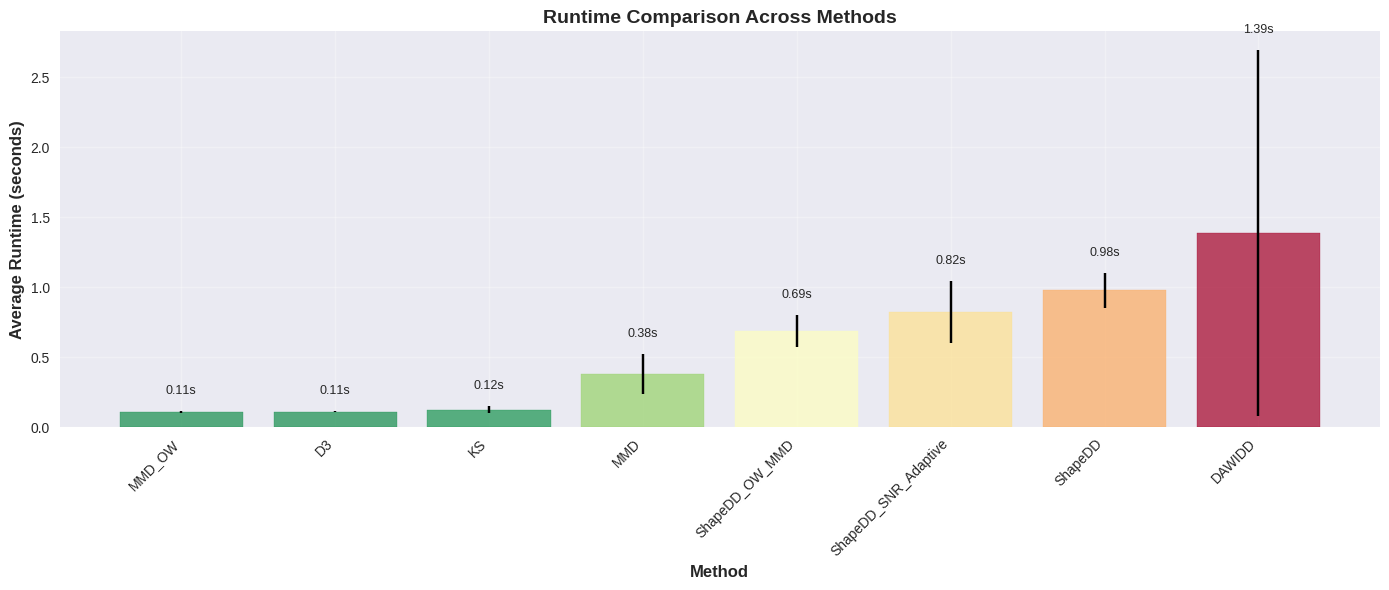

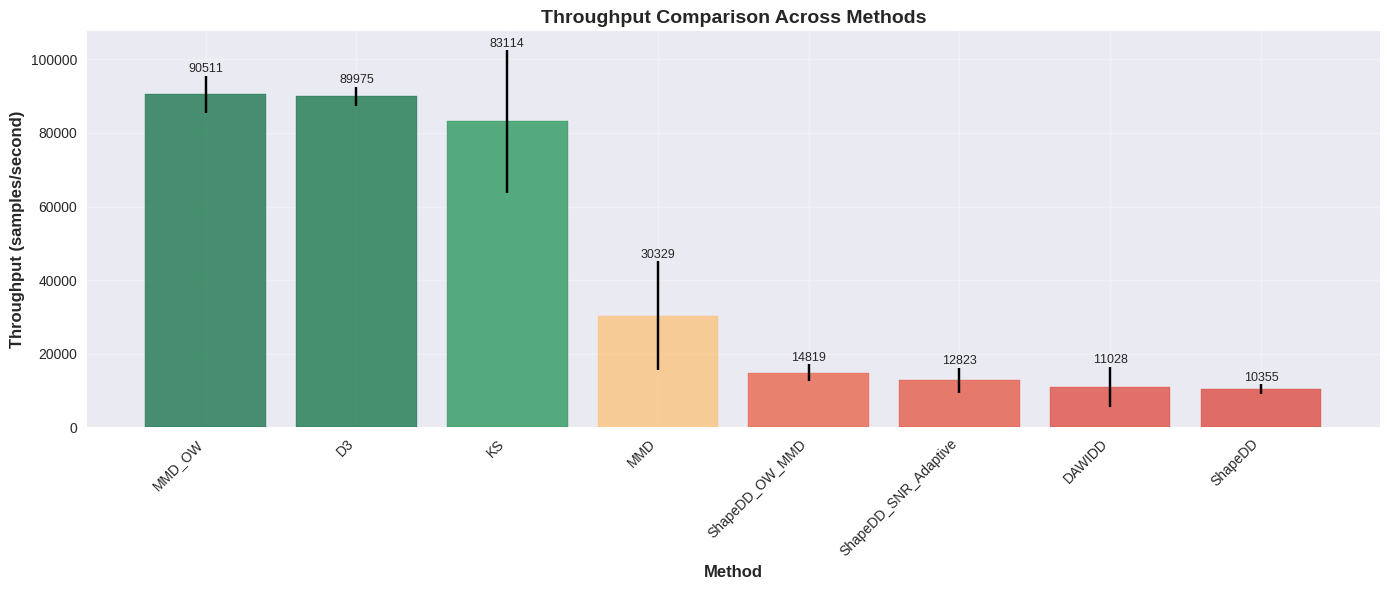

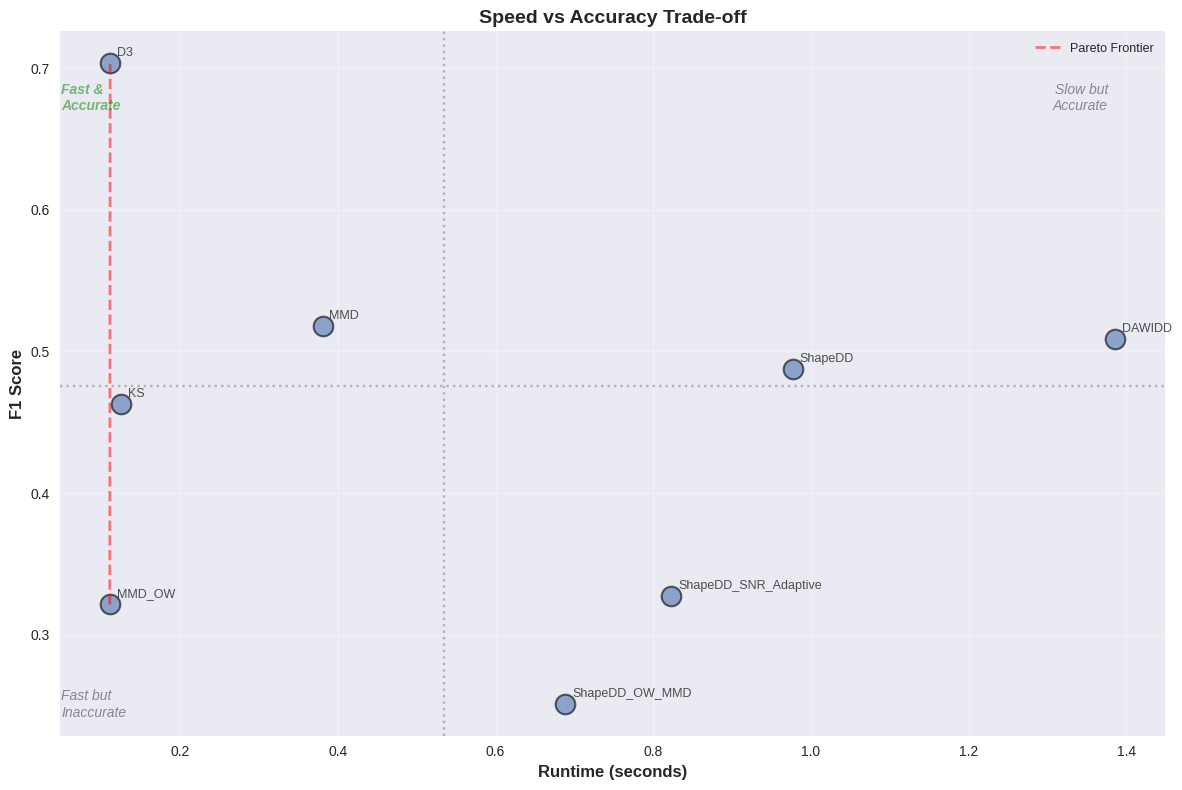

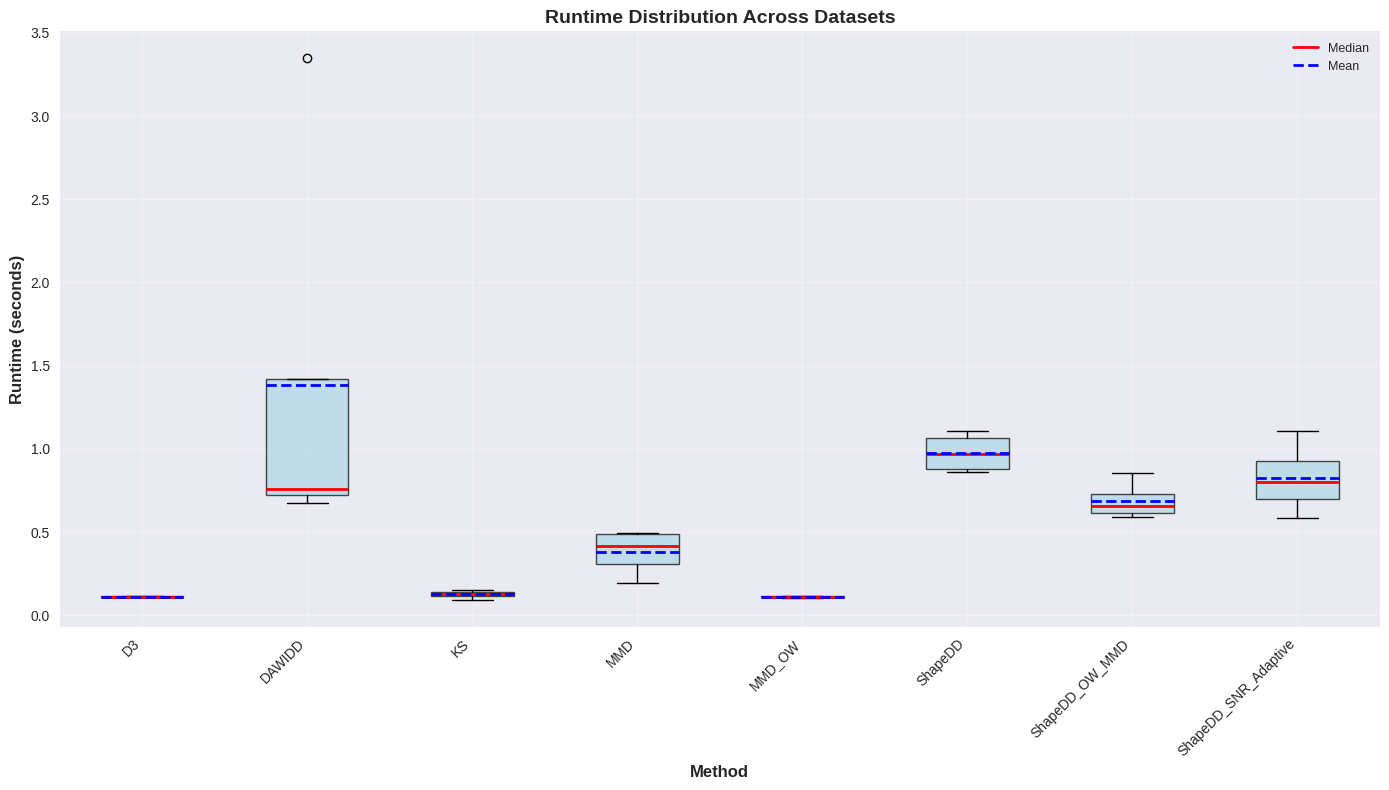

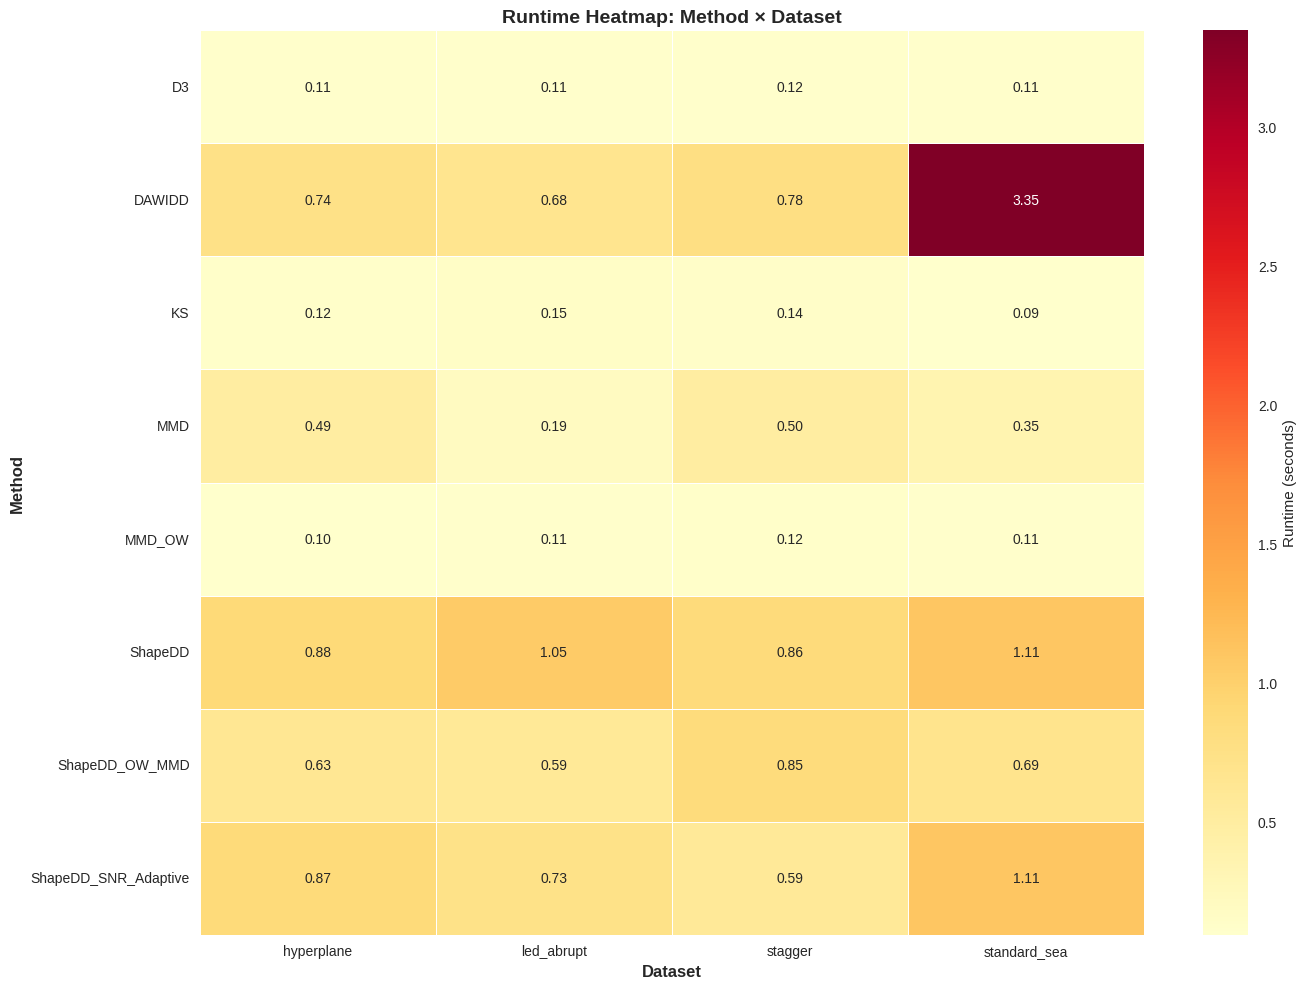

In [11]:
# ============================================================================
# SECTION 7E: RUNTIME & RESOURCE USAGE VISUALIZATION
# ============================================================================

# ============================================================================
# PLOT 1: Runtime Comparison Bar Chart
# ============================================================================

def plot_runtime_comparison(results_df):
    """
    Compare average runtime across methods
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    # Calculate mean runtime per method across all datasets
    runtime_summary = results_df.groupby('Method').agg({
        'Runtime_s': ['mean', 'std']
    }).reset_index()

    runtime_summary.columns = ['Method', 'Mean_Runtime', 'Std_Runtime']
    runtime_summary = runtime_summary.sort_values('Mean_Runtime')

    # Create bar plot
    x = np.arange(len(runtime_summary))
    bars = ax.bar(x, runtime_summary['Mean_Runtime'],
                   yerr=runtime_summary['Std_Runtime'],
                   capsize=5, alpha=0.7, edgecolor='black')

    # Color bars by runtime (green = fast, red = slow)
    max_runtime = runtime_summary['Mean_Runtime'].max()
    for i, bar in enumerate(bars):
        normalized = runtime_summary.iloc[i]['Mean_Runtime'] / max_runtime
        bar.set_color(plt.cm.RdYlGn_r(normalized))

    ax.set_xlabel('Method', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Runtime (seconds)', fontsize=12, fontweight='bold')
    ax.set_title('Runtime Comparison Across Methods', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(runtime_summary['Method'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (mean_val, std_val) in enumerate(zip(runtime_summary['Mean_Runtime'],
                                                  runtime_summary['Std_Runtime'])):
        ax.text(i, mean_val + std_val + 0.1, f'{mean_val:.2f}s',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('runtime_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: runtime_comparison.png")
    return fig


# ============================================================================
# PLOT 2: Throughput Comparison
# ============================================================================

def plot_throughput_comparison(results_df):
    """
    Compare throughput (samples/second) across methods
    """
    if 'Throughput' not in results_df.columns:
        print("⚠ Throughput column not found, skipping this plot")
        return None

    fig, ax = plt.subplots(figsize=(14, 6))

    # Calculate mean throughput per method
    throughput_summary = results_df.groupby('Method').agg({
        'Throughput': ['mean', 'std']
    }).reset_index()

    throughput_summary.columns = ['Method', 'Mean_Throughput', 'Std_Throughput']
    throughput_summary = throughput_summary.sort_values('Mean_Throughput', ascending=False)

    # Create bar plot
    x = np.arange(len(throughput_summary))
    bars = ax.bar(x, throughput_summary['Mean_Throughput'],
                   yerr=throughput_summary['Std_Throughput'],
                   capsize=5, alpha=0.7, edgecolor='black')

    # Color bars (green = fast, red = slow)
    max_throughput = throughput_summary['Mean_Throughput'].max()
    for i, bar in enumerate(bars):
        normalized = throughput_summary.iloc[i]['Mean_Throughput'] / max_throughput
        bar.set_color(plt.cm.RdYlGn(normalized))

    ax.set_xlabel('Method', fontsize=12, fontweight='bold')
    ax.set_ylabel('Throughput (samples/second)', fontsize=12, fontweight='bold')
    ax.set_title('Throughput Comparison Across Methods', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(throughput_summary['Method'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (mean_val, std_val) in enumerate(zip(throughput_summary['Mean_Throughput'],
                                                  throughput_summary['Std_Throughput'])):
        ax.text(i, mean_val + std_val + 100, f'{mean_val:.0f}',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('throughput_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: throughput_comparison.png")
    return fig


# ============================================================================
# PLOT 3: Runtime vs F1 Score Scatter (Speed-Accuracy Trade-off)
# ============================================================================

def plot_runtime_vs_f1(results_df):
    """
    Scatter plot showing trade-off between speed and accuracy
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    # Calculate mean F1 and Runtime per method
    summary = results_df.groupby('Method').agg({
        'F1': 'mean',
        'Runtime_s': 'mean'
    }).reset_index()

    # Create scatter plot
    scatter = ax.scatter(summary['Runtime_s'], summary['F1'],
                        s=200, alpha=0.6, edgecolors='black', linewidth=1.5)

    # Add method labels
    for idx, row in summary.iterrows():
        ax.annotate(row['Method'],
                   (row['Runtime_s'], row['F1']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, alpha=0.8)

    # Highlight Pareto frontier (best trade-off)
    # Sort by runtime
    summary_sorted = summary.sort_values('Runtime_s')
    pareto_front = []
    max_f1_so_far = -1

    for idx, row in summary_sorted.iterrows():
        if row['F1'] > max_f1_so_far:
            pareto_front.append(idx)
            max_f1_so_far = row['F1']

    if len(pareto_front) > 0:
        pareto_df = summary.loc[pareto_front].sort_values('Runtime_s')
        ax.plot(pareto_df['Runtime_s'], pareto_df['F1'],
               'r--', linewidth=2, alpha=0.5, label='Pareto Frontier')

    ax.set_xlabel('Runtime (seconds)', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax.set_title('Speed vs Accuracy Trade-off', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Add quadrant lines (median)
    median_runtime = summary['Runtime_s'].median()
    median_f1 = summary['F1'].median()
    ax.axvline(median_runtime, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(median_f1, color='gray', linestyle=':', alpha=0.5)

    # Add quadrant labels
    ax.text(ax.get_xlim()[1] * 0.95, ax.get_ylim()[1] * 0.95,
           'Slow but\nAccurate', ha='right', va='top',
           fontsize=10, alpha=0.5, style='italic')
    ax.text(ax.get_xlim()[0] * 1.05, ax.get_ylim()[1] * 0.95,
           'Fast &\nAccurate', ha='left', va='top',
           fontsize=10, alpha=0.5, style='italic', color='green', weight='bold')
    ax.text(ax.get_xlim()[0] * 1.05, ax.get_ylim()[0] * 1.05,
           'Fast but\nInaccurate', ha='left', va='bottom',
           fontsize=10, alpha=0.5, style='italic')

    plt.tight_layout()
    plt.savefig('runtime_vs_f1.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: runtime_vs_f1.png")
    return fig


# ============================================================================
# PLOT 4: Runtime Distribution Box Plot
# ============================================================================

def plot_runtime_distribution(results_df):
    """
    Box plot showing runtime distribution across datasets for each method
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # Prepare data for box plot
    methods = sorted(results_df['Method'].unique())
    data_to_plot = [results_df[results_df['Method'] == method]['Runtime_s'].values
                    for method in methods]

    # Create box plot
    bp = ax.boxplot(data_to_plot, labels=methods, patch_artist=True,
                    showmeans=True, meanline=True,
                    medianprops={'color': 'red', 'linewidth': 2},
                    meanprops={'color': 'blue', 'linewidth': 2, 'linestyle': '--'})

    # Color boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    ax.set_xlabel('Method', fontsize=12, fontweight='bold')
    ax.set_ylabel('Runtime (seconds)', fontsize=12, fontweight='bold')
    ax.set_title('Runtime Distribution Across Datasets', fontsize=14, fontweight='bold')
    ax.set_xticklabels(methods, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', linewidth=2, label='Median'),
        Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='Mean')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig('runtime_distribution.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: runtime_distribution.png")
    return fig


# ============================================================================
# PLOT 5: Heatmap - Runtime by Method and Dataset
# ============================================================================

def plot_runtime_heatmap(results_df):
    """
    Heatmap showing runtime for each method on each dataset
    """
    # Create pivot table
    pivot = results_df.pivot_table(values='Runtime_s',
                                   index='Method',
                                   columns='Dataset',
                                   aggfunc='mean')

    fig, ax = plt.subplots(figsize=(14, 10))

    # Create heatmap
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd',
                cbar_kws={'label': 'Runtime (seconds)'},
                linewidths=0.5, ax=ax)

    ax.set_title('Runtime Heatmap: Method × Dataset', fontsize=14, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax.set_ylabel('Method', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('runtime_heatmap.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: runtime_heatmap.png")
    return fig


# ============================================================================


# ============================================================================
# GENERATE ALL RUNTIME PLOTS
# ============================================================================

if len(all_results) == 0:
    print("⚠ NO RESULTS - Run benchmark first (Cell 6)")
else:
    print("=" * 80)
    print("GENERATING RUNTIME & RESOURCE USAGE PLOTS")
    print("=" * 80)
    print()

    # Generate all plots
    figs = []

    print("[1/5] Runtime Comparison Bar Chart...")
    figs.append(plot_runtime_comparison(results_df))

    print("[2/5] Throughput Comparison...")
    figs.append(plot_throughput_comparison(results_df))

    print("[3/5] Speed vs Accuracy Trade-off...")
    figs.append(plot_runtime_vs_f1(results_df))

    print("[4/5] Runtime Distribution Box Plot...")
    figs.append(plot_runtime_distribution(results_df))

    print("[5/5] Runtime Heatmap...")
    figs.append(plot_runtime_heatmap(results_df))




Generating detection timelines for 4 dataset(s)...


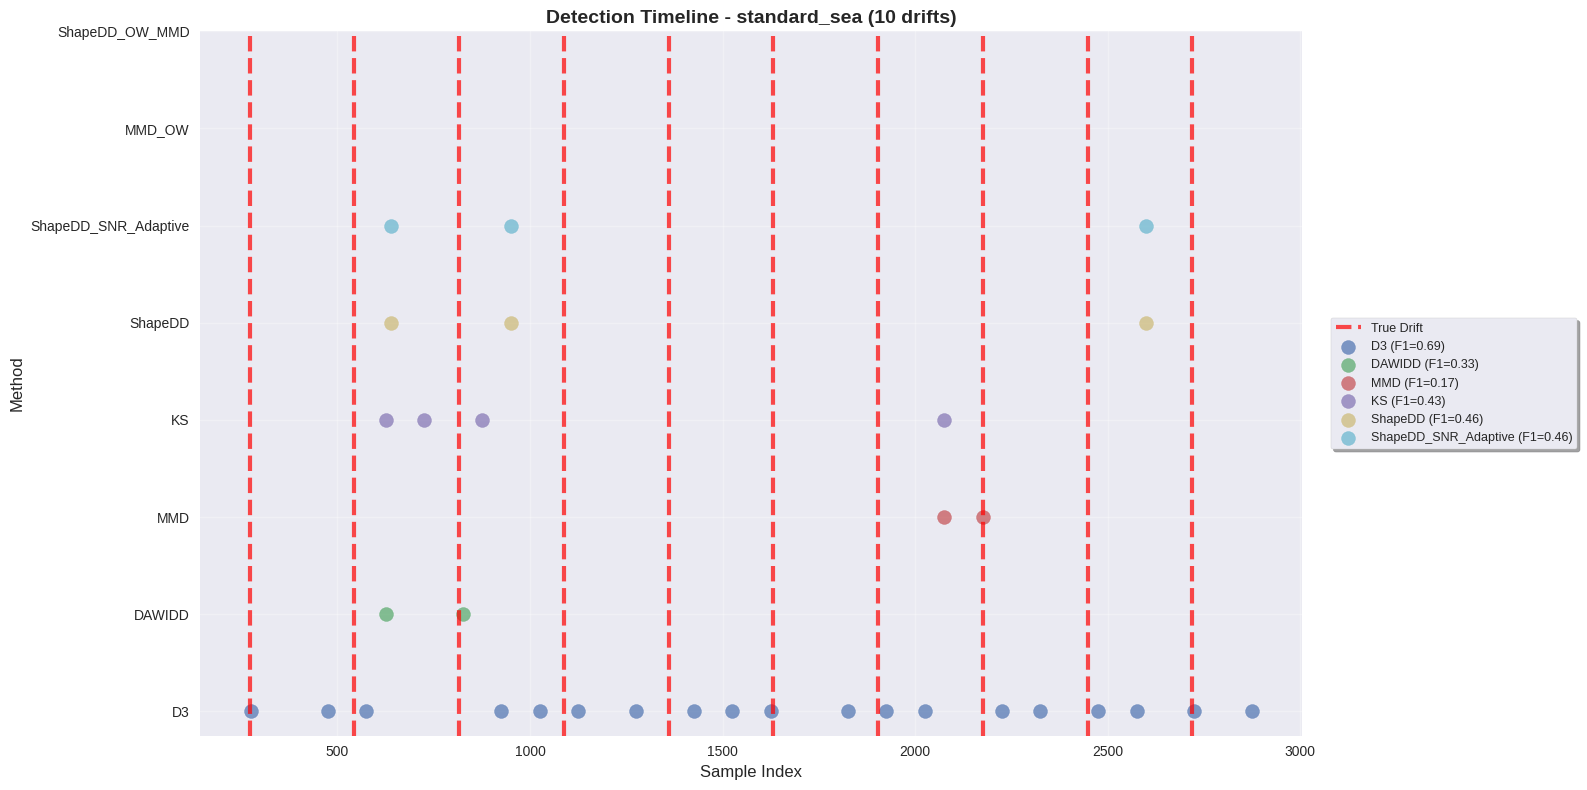

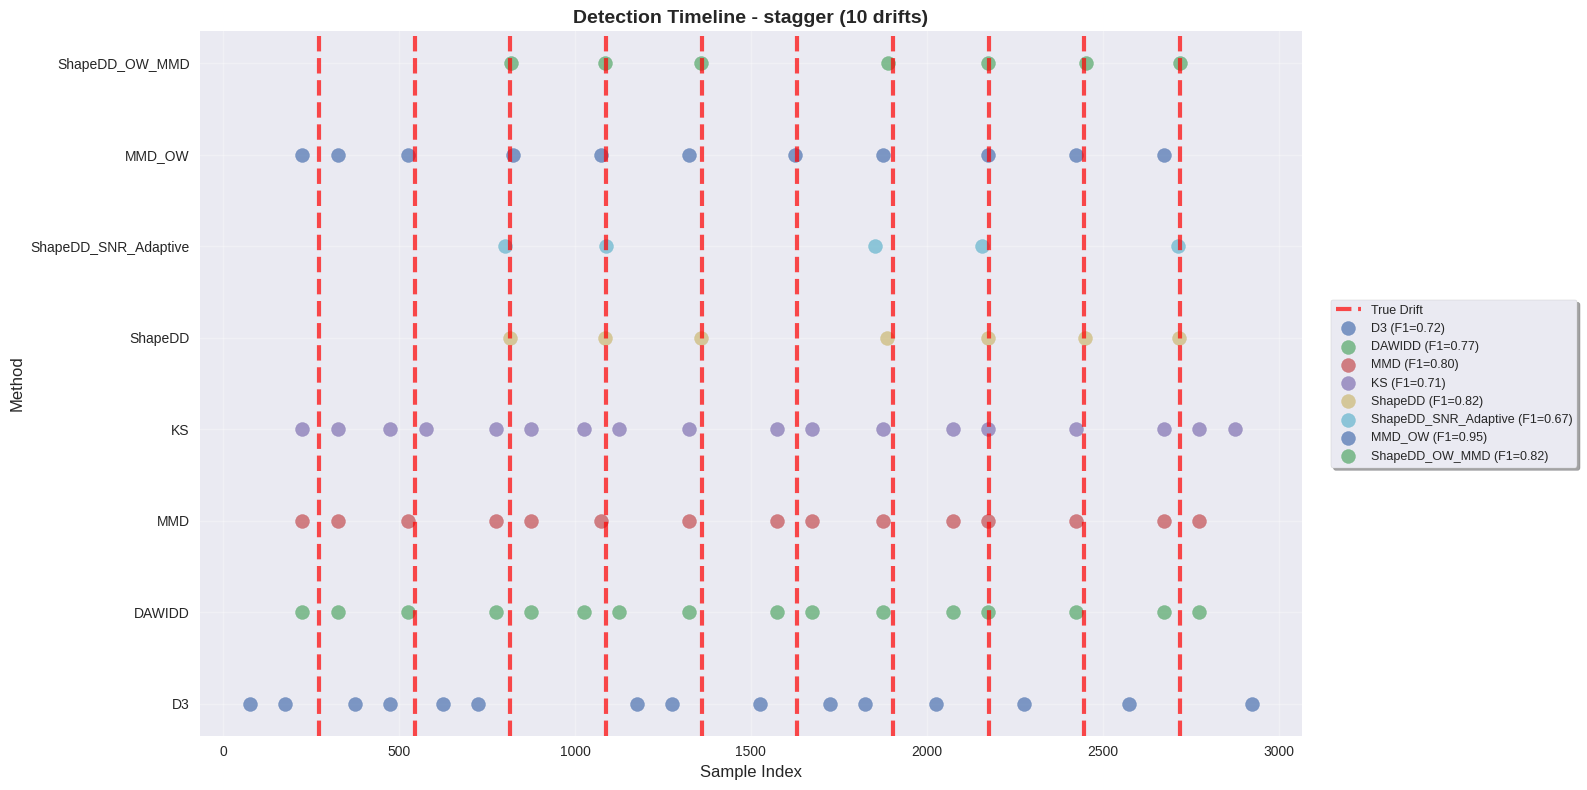

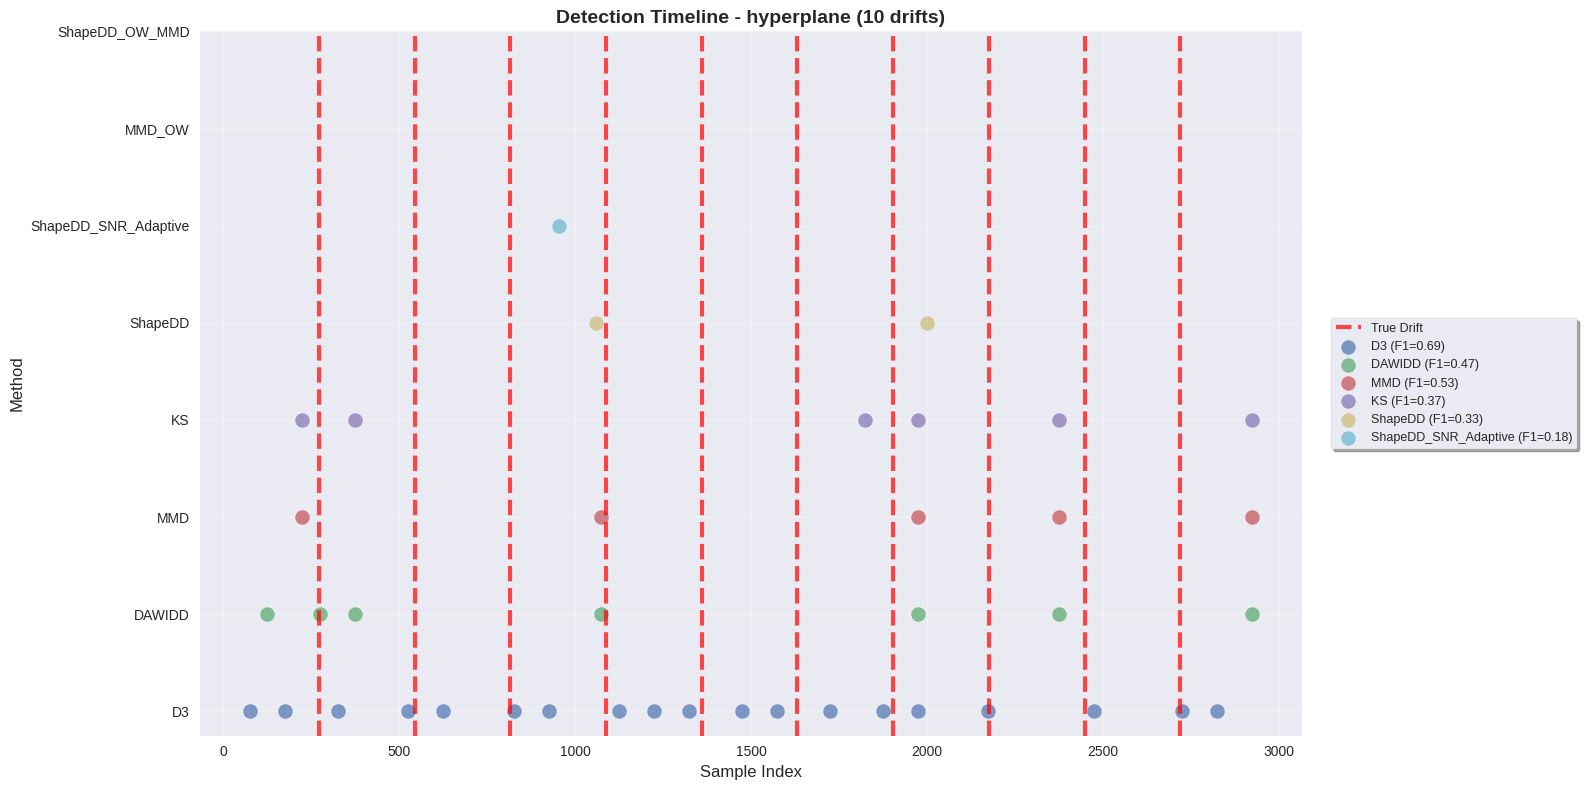

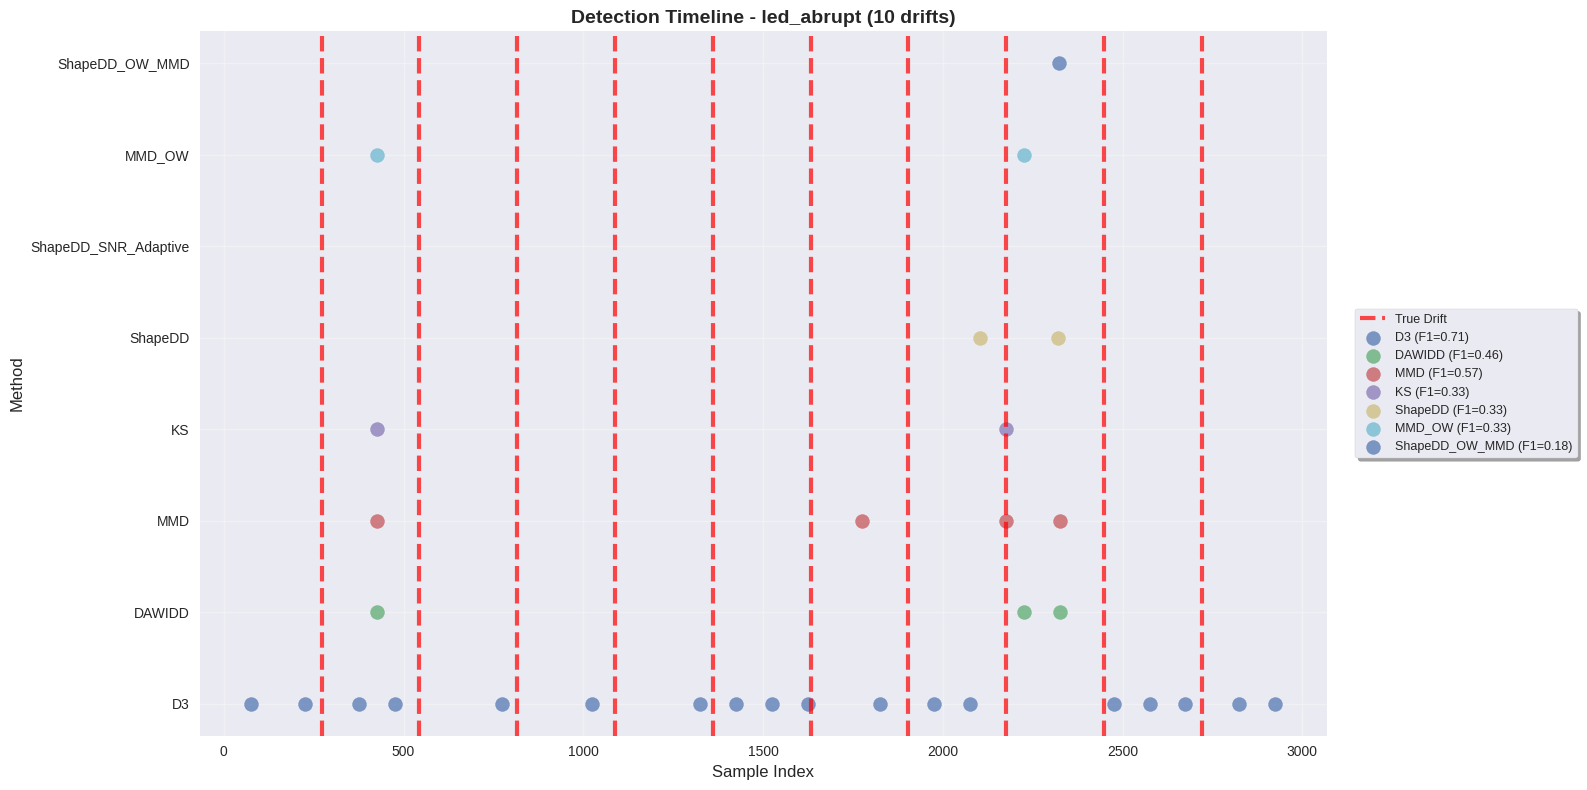

✓ Generated 4 detection timeline plot(s)


In [12]:
# ============================================================================
# SECTION 8: VISUALIZATION - DETECTION TIMELINES
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    # Get unique datasets from actual results (only enabled datasets)
    datasets = results_df['Dataset'].unique()
    print(f"Generating detection timelines for {len(datasets)} dataset(s)...")

    for dataset_name in datasets:
        dataset_results = [r for r in all_results if r['dataset'] == dataset_name]

        if not dataset_results:
            continue

        true_drifts = dataset_results[0]['drift_positions']
        n_drifts = len(true_drifts)

        fig, ax = plt.subplots(figsize=(16, 8))  # Wider figure for external legend

        # Plot true drifts
        for i, drift_pos in enumerate(true_drifts):
            ax.axvline(drift_pos, color='red', linestyle='--', linewidth=3,
                      alpha=0.7, label='True Drift' if i == 0 else '')

        # Plot detections
        for idx, result in enumerate(dataset_results):
            detections = result['detections']
            method = result['method']

            if detections:
                ax.scatter(detections, [idx]*len(detections), s=100, alpha=0.7,
                          label=f"{method} (F1={result['f1_score']:.2f})")

        ax.set_yticks(range(len(dataset_results)))
        ax.set_yticklabels([r['method'] for r in dataset_results])
        ax.set_xlabel('Sample Index', fontsize=12)
        ax.set_ylabel('Method', fontsize=12)
        ax.set_title(f'Detection Timeline - {dataset_name} ({n_drifts} drifts)',
                    fontsize=14, fontweight='bold')
        
        # Move legend outside plot area (to the right)
        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9,
                 frameon=True, fancybox=True, shadow=True)
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    print(f"✓ Generated {len(datasets)} detection timeline plot(s)")


In [13]:
# ============================================================================
# SECTION 11: EXPORT VISUALIZATIONS FOR THESIS (ALL IN ENGLISH)
# ============================================================================
# Run the master script (generates all 7 figures)
%run generate_all_figures.py


GENERATING ALL THESIS FIGURES (ENGLISH LABELS)

Step 1/2: Generating performance visualizations (6 figures)...
--------------------------------------------------------------------------------
Creating All Thesis Visualizations (Auto-Extract from Notebook)

📊 Extracting results from notebook...
   Attempting to extract from notebook JSON...
   ⚠️  Could not extract from notebook JSON
   Using fallback: Load from summary output or hardcoded values
   Attempting to execute notebook and extract variables...
   ✓ Loaded results_df with 32 rows
   ✓ Successfully loaded results_df with 32 rows
   ✓ Aggregated to 8 methods

Top 5 Methods:
 Rank  Method       F1  Recall
    1      D3 0.703399   0.975
    2     MMD 0.517857   0.475
    3  DAWIDD 0.508673   0.475
    4 ShapeDD 0.487934   0.350
    5      KS 0.462798   0.450

📈 SNR-Adaptive: F1=0.328, Recall=0.2%, Rank=6/8

1. Creating Strategy Selection Distribution...
   ✓ Saved: strategy_selection.png

2. Creating Performance Comparison Bar Cha

In [14]:
# ============================================================================
# SECTION 12: PUBLICATION-QUALITY SETUP
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# Create output directory for publication-ready figures
output_dir = Path("./publication_figures")
output_dir.mkdir(exist_ok=True)

# Publication-quality matplotlib settings
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'text.usetex': False,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'axes.grid': False,
    'axes.spines.top': True,
    'axes.spines.right': True,
})

sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.3})

print("✓ Publication settings configured")
print(f"✓ Output directory: {output_dir.absolute()}")
print(f"✓ DPI: 300 (publication quality)")
print(f"✓ Font: Times New Roman/Serif")


✓ Publication settings configured
✓ Output directory: /home/lpd1hc/sandboxes/One-or-Two-Things-We-Know-about-Concept-Drift/experiments/notebooks/publication_figures
✓ DPI: 300 (publication quality)
✓ Font: Times New Roman/Serif


In [15]:
# ============================================================================
# SECTION 13: PUBLICATION TABLE I - LaTeX Format
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first (Cell 6)")
else:
    print("\n" + "="*100)
    print("TABLE I: COMPREHENSIVE PERFORMANCE - LaTeX FORMAT")
    print("="*100)

    drift_results_df = results_df[results_df['N_Drifts'] > 0].copy()

    method_stats = drift_results_df.groupby('Method').agg({
        'F1': ['mean', 'std'],
        'Precision': 'mean',
        'Recall': 'mean',
        'MTTD': 'mean',
        'TP': 'sum',
        'FP': 'sum',
        'FN': 'sum'
    }).round(4)

    pub_table = pd.DataFrame({
        'Method': method_stats.index,
        'F1': method_stats[('F1', 'mean')],
        'F1_std': method_stats[('F1', 'std')],
        'Precision': method_stats[('Precision', 'mean')],
        'Recall': method_stats[('Recall', 'mean')],
        'MTTD': method_stats[('MTTD', 'mean')].fillna(0).astype(int),
        'TP': method_stats[('TP', 'sum')].astype(int),
        'FP': method_stats[('FP', 'sum')].astype(int),
        'FN': method_stats[('FN', 'sum')].astype(int)
    })

    pub_table = pub_table.sort_values('F1', ascending=False).reset_index(drop=True)
    pub_table['F1_formatted'] = pub_table.apply(
        lambda row: f"${row['F1']:.3f} \\pm {row['F1_std']:.3f}$", axis=1
    )

    latex_table = pub_table[['Method', 'F1_formatted', 'Precision', 'Recall', 'MTTD', 'TP', 'FP', 'FN']].copy()
    latex_table.columns = ['Method', 'F1 ($\\mu \\pm \\sigma$)', 'Precision', 'Recall', 'MTTD', 'TP', 'FP', 'FN']

    for col in ['Precision', 'Recall']:
        latex_table[col] = latex_table[col].apply(lambda x: f"{x:.3f}")

    latex_output = latex_table.to_latex(
        index=False,
        escape=False,
        column_format='l' + 'c' * (len(latex_table.columns) - 1),
        caption='Comprehensive drift detection performance across drift datasets.',
        label='tab:comprehensive_performance',
        position='htbp'
    )

    latex_file = output_dir / "table_I_comprehensive_performance.tex"
    with open(latex_file, 'w') as f:
        f.write(latex_output)

    print(f"✓ LaTeX table saved: {latex_file}")
    print("\nPreview (first 5 methods):")
    print(latex_table.head().to_string())
    print("\n" + "="*100)



TABLE I: COMPREHENSIVE PERFORMANCE - LaTeX FORMAT
✓ LaTeX table saved: publication_figures/table_I_comprehensive_performance.tex

Preview (first 5 methods):
    Method F1 ($\mu \pm \sigma$) Precision Recall  MTTD  TP  FP  FN
0       D3     $0.703 \pm 0.016$     0.552  0.975    51  39  32   1
1      MMD     $0.518 \pm 0.262$     0.742  0.475    44  19   7  21
2   DAWIDD     $0.509 \pm 0.185$     0.799  0.475    53  19   9  21
3  ShapeDD     $0.488 \pm 0.232$     1.000  0.350    70  14   0  26
4       KS     $0.463 \pm 0.172$     0.701  0.450    59  18  12  22



In [16]:
# ============================================================================
# SECTION 14: PUBLICATION TABLE II - Performance by Drift Type
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("\n" + "="*100)
    print("TABLE II: PERFORMANCE BY DRIFT TYPE - LaTeX FORMAT")
    print("="*100)

    def categorize_drift_type(dataset_name):
        gradual_keywords = ['gradual', 'circles', 'agrawal_gradual', 'hyperplane_gradual']
        incremental_keywords = ['rbf', 'hyperplane']
        stationary_keywords = ['none']
        dataset_lower = dataset_name.lower()
        if any(k in dataset_lower for k in stationary_keywords):
            return 'Stationary'
        elif any(k in dataset_lower for k in gradual_keywords):
            return 'Gradual'
        elif any(k in dataset_lower for k in incremental_keywords):
            return 'Incremental'
        elif 'electricity' in dataset_lower:
            return 'Real-World'
        else:
            return 'Sudden'

    # Categorize datasets based on what's actually in results
    results_df['Drift_Type'] = results_df['Dataset'].apply(categorize_drift_type)

    # Get categories that actually exist in the results
    existing_categories = results_df['Drift_Type'].unique()
    print(f"Found drift types in results: {', '.join(sorted(existing_categories))}")

    drift_type_stats = results_df.groupby(['Method', 'Drift_Type']).agg({
        'F1': 'mean',
        'Precision': 'mean',
        'Recall': 'mean',
        'MTTD': 'mean'
    }).reset_index()

    f1_by_type = drift_type_stats.pivot(index='Method', columns='Drift_Type', values='F1')
    
    # Calculate average only for drift categories (exclude Stationary if present)
    drift_cols = [c for c in f1_by_type.columns if c != 'Stationary']
    if drift_cols:
        f1_by_type['Avg'] = f1_by_type[drift_cols].mean(axis=1)
        f1_by_type = f1_by_type.sort_values('Avg', ascending=False)
    else:
        # If no drift columns, just sort by first available column
        f1_by_type = f1_by_type.sort_values(f1_by_type.columns[0], ascending=False)

    latex_output_drift = f1_by_type.to_latex(
        float_format='%.3f',
        caption='F1-score performance stratified by drift type.',
        label='tab:performance_by_drift_type',
        column_format='l' + 'c' * len(f1_by_type.columns),
        position='htbp'
    )

    latex_file_drift = output_dir / "table_II_performance_by_drift_type.tex"
    with open(latex_file_drift, 'w') as f:
        f.write(latex_output_drift)

    print(f"✓ LaTeX table saved: {latex_file_drift}")
    print(f"\nPreview ({len(f1_by_type.columns)} drift type categories):")
    print(f1_by_type.to_string())
    print("="*100)



TABLE II: PERFORMANCE BY DRIFT TYPE - LaTeX FORMAT
Found drift types in results: Incremental, Sudden
✓ LaTeX table saved: publication_figures/table_II_performance_by_drift_type.tex

Preview (3 drift type categories):
Drift_Type            Incremental    Sudden       Avg
Method                                               
D3                       0.689655  0.707980  0.698818
MMD                      0.533333  0.512698  0.523016
DAWIDD                   0.470588  0.521368  0.495978
ShapeDD                  0.333333  0.539467  0.436400
KS                       0.375000  0.492063  0.433532
ShapeDD_SNR_Adaptive     0.181818  0.376068  0.278943
MMD_OW                   0.000000  0.428571  0.214286
ShapeDD_OW_MMD           0.000000  0.335116  0.167558


Generating Figure 1: F1-Score Heatmap (sorted by category)...
✓ Saved: publication_figures/figure_1_f1_heatmap.png
✓ Saved: publication_figures/figure_1_f1_heatmap.pdf


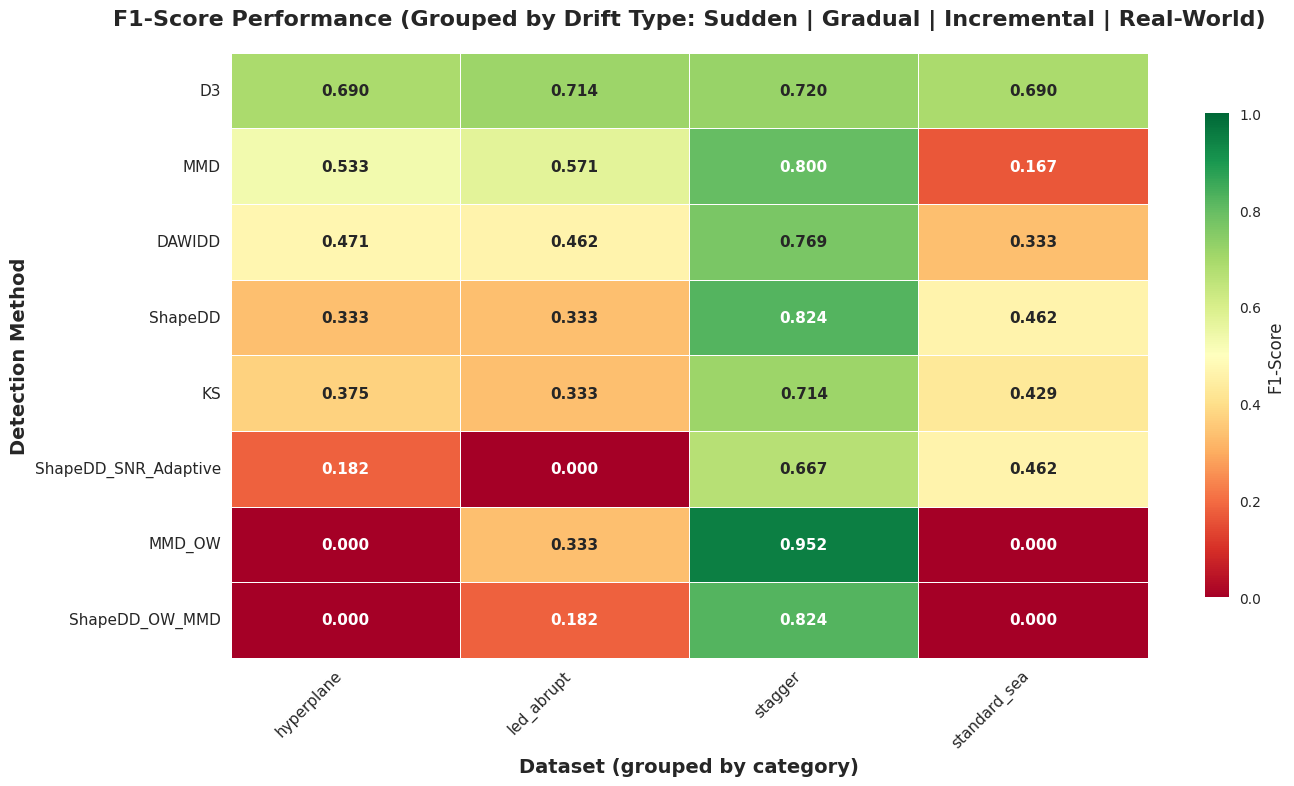

Figure 1 complete (4 datasets grouped by category)



In [17]:
# ============================================================================
# SECTION 15: PUBLICATION FIGURE 1 - F1-Score Heatmap
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("Generating Figure 1: F1-Score Heatmap (sorted by category)...")

    drift_datasets = results_df[results_df['N_Drifts'] > 0].copy()
    
    # Only use datasets that are actually in the results
    if len(drift_datasets) == 0:
        print("⚠ No drift datasets with results found")
    else:
        f1_pivot = drift_datasets.pivot_table(values='F1', index='Method', columns='Dataset', aggfunc='mean')
        
        # Sort methods by average F1
        f1_pivot['_avg'] = f1_pivot.mean(axis=1)
        f1_pivot = f1_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
        
        # Sort datasets by category: Sudden > Gradual > Incremental > Real-World
        def categorize_drift_type(dataset_name):
            gradual_keywords = ['gradual', 'circles']
            incremental_keywords = ['rbf']
            dataset_lower = dataset_name.lower()
            if any(k in dataset_lower for k in gradual_keywords):
                return 'B_Gradual'
            elif any(k in dataset_lower for k in incremental_keywords):
                return 'C_Incremental'
            elif 'electricity' in dataset_lower:
                return 'D_Real-World'
            else:
                return 'A_Sudden'
        
        # Only categorize datasets that exist in the pivot table
        dataset_categories = {col: categorize_drift_type(col) for col in f1_pivot.columns}
        sorted_columns = sorted(f1_pivot.columns, key=lambda x: (dataset_categories[x], x))
        f1_pivot = f1_pivot[sorted_columns]

        fig, ax = plt.subplots(figsize=(max(14, len(sorted_columns) * 1.2), max(8, len(f1_pivot) * 0.6)))
        sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                   cbar_kws={'label': 'F1-Score', 'shrink': 0.8, 'aspect': 20},
                   linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)

        ax.set_title('F1-Score Performance (Grouped by Drift Type: Sudden | Gradual | Incremental | Real-World)',
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Dataset (grouped by category)', fontsize=14, fontweight='bold')
        ax.set_ylabel('Detection Method', fontsize=14, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
        
        # Add vertical lines to separate categories (only if multiple categories exist)
        unique_categories = set(dataset_categories.values())
        if len(unique_categories) > 1:
            prev_cat = None
            for idx, col in enumerate(f1_pivot.columns):
                cat = dataset_categories[col]
                if prev_cat is not None and cat != prev_cat:
                    ax.axvline(x=idx, color='black', linewidth=2, linestyle='--', alpha=0.5)
                prev_cat = cat

        plt.tight_layout()

        for fmt in ['png', 'pdf']:
            filepath = output_dir / f"figure_1_f1_heatmap.{fmt}"
            plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
            print(f"✓ Saved: {filepath}")

        plt.show()
        print(f"Figure 1 complete ({len(sorted_columns)} datasets grouped by category)\n")


Generating Figure 2: Precision Heatmap (sorted by category)...
✓ Saved: publication_figures/figure_2_precision_heatmap.png
✓ Saved: publication_figures/figure_2_precision_heatmap.pdf


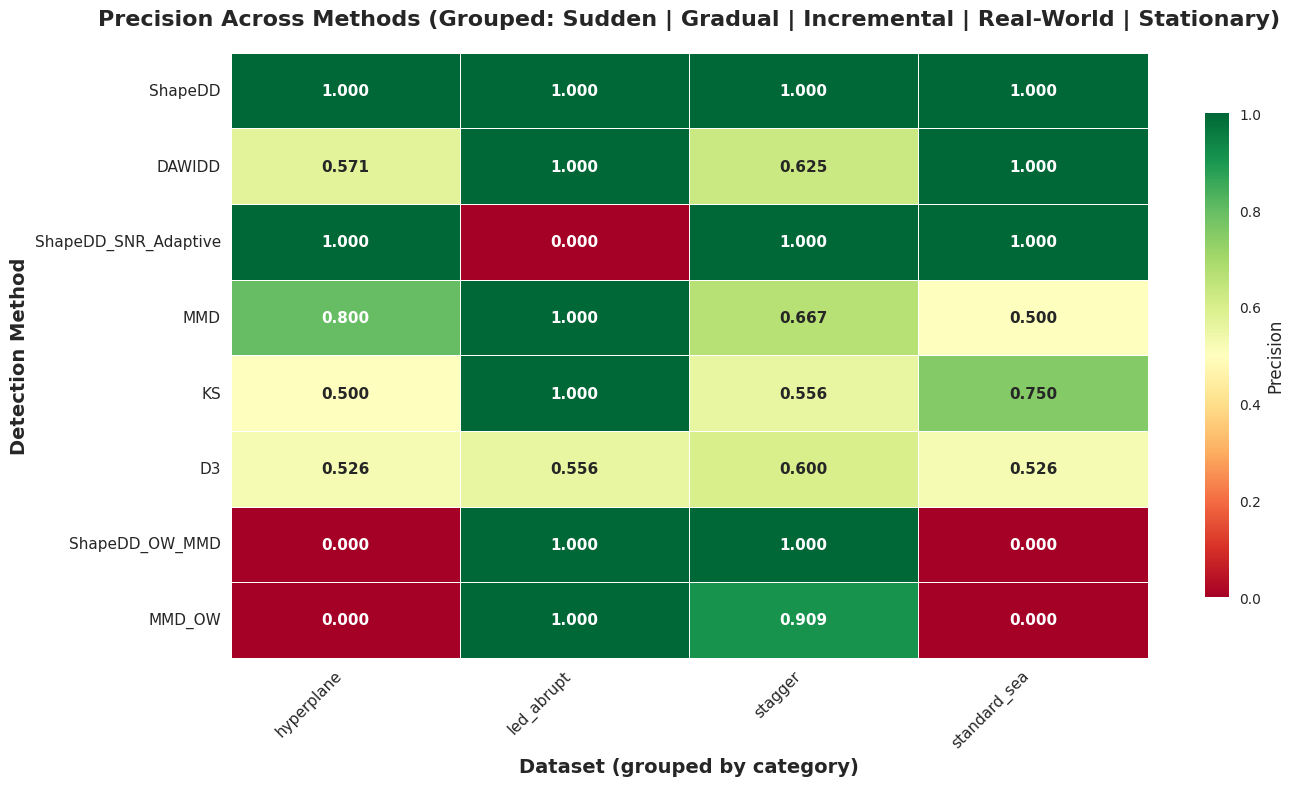

Figure 2 complete (4 datasets grouped by category)



In [18]:
# ============================================================================
# SECTION 16: PUBLICATION FIGURE 2 - Precision Heatmap
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("Generating Figure 2: Precision Heatmap (sorted by category)...")

    # Only use datasets that are actually in the results
    precision_pivot = results_df.pivot_table(values='Precision', index='Method', columns='Dataset', aggfunc='mean')
    
    if len(precision_pivot.columns) == 0:
        print("⚠ No datasets with results found")
    else:
        # Sort methods by average precision
        precision_pivot['_avg'] = precision_pivot.mean(axis=1)
        precision_pivot = precision_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
        
        # Sort datasets by category
        def categorize_drift_type(dataset_name):
            gradual_keywords = ['gradual', 'circles']
            incremental_keywords = ['rbf']
            stationary_keywords = ['none']
            dataset_lower = dataset_name.lower()
            if any(k in dataset_lower for k in stationary_keywords):
                return 'E_Stationary'
            elif any(k in dataset_lower for k in gradual_keywords):
                return 'B_Gradual'
            elif any(k in dataset_lower for k in incremental_keywords):
                return 'C_Incremental'
            elif 'electricity' in dataset_lower:
                return 'D_Real-World'
            else:
                return 'A_Sudden'
        
        # Only categorize datasets that exist in the pivot table
        dataset_categories = {col: categorize_drift_type(col) for col in precision_pivot.columns}
        sorted_columns = sorted(precision_pivot.columns, key=lambda x: (dataset_categories[x], x))
        precision_pivot = precision_pivot[sorted_columns]

        fig, ax = plt.subplots(figsize=(max(14, len(sorted_columns) * 1.2), max(8, len(precision_pivot) * 0.6)))
        sns.heatmap(precision_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                   cbar_kws={'label': 'Precision', 'shrink': 0.8, 'aspect': 20},
                   linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)

        ax.set_title('Precision Across Methods (Grouped: Sudden | Gradual | Incremental | Real-World | Stationary)',
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Dataset (grouped by category)', fontsize=14, fontweight='bold')
        ax.set_ylabel('Detection Method', fontsize=14, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
        
        # Add vertical lines to separate categories (only if multiple categories exist)
        unique_categories = set(dataset_categories.values())
        if len(unique_categories) > 1:
            prev_cat = None
            for idx, col in enumerate(precision_pivot.columns):
                cat = dataset_categories[col]
                if prev_cat is not None and cat != prev_cat:
                    ax.axvline(x=idx, color='black', linewidth=2, linestyle='--', alpha=0.5)
                prev_cat = cat

        plt.tight_layout()

        for fmt in ['png', 'pdf']:
            filepath = output_dir / f"figure_2_precision_heatmap.{fmt}"
            plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
            print(f"✓ Saved: {filepath}")

        plt.show()
        print(f"Figure 2 complete ({len(sorted_columns)} datasets grouped by category)\n")


Generating Figure 3: Recall Heatmap (sorted by category)...
✓ Saved: publication_figures/figure_3_recall_heatmap.png
✓ Saved: publication_figures/figure_3_recall_heatmap.pdf


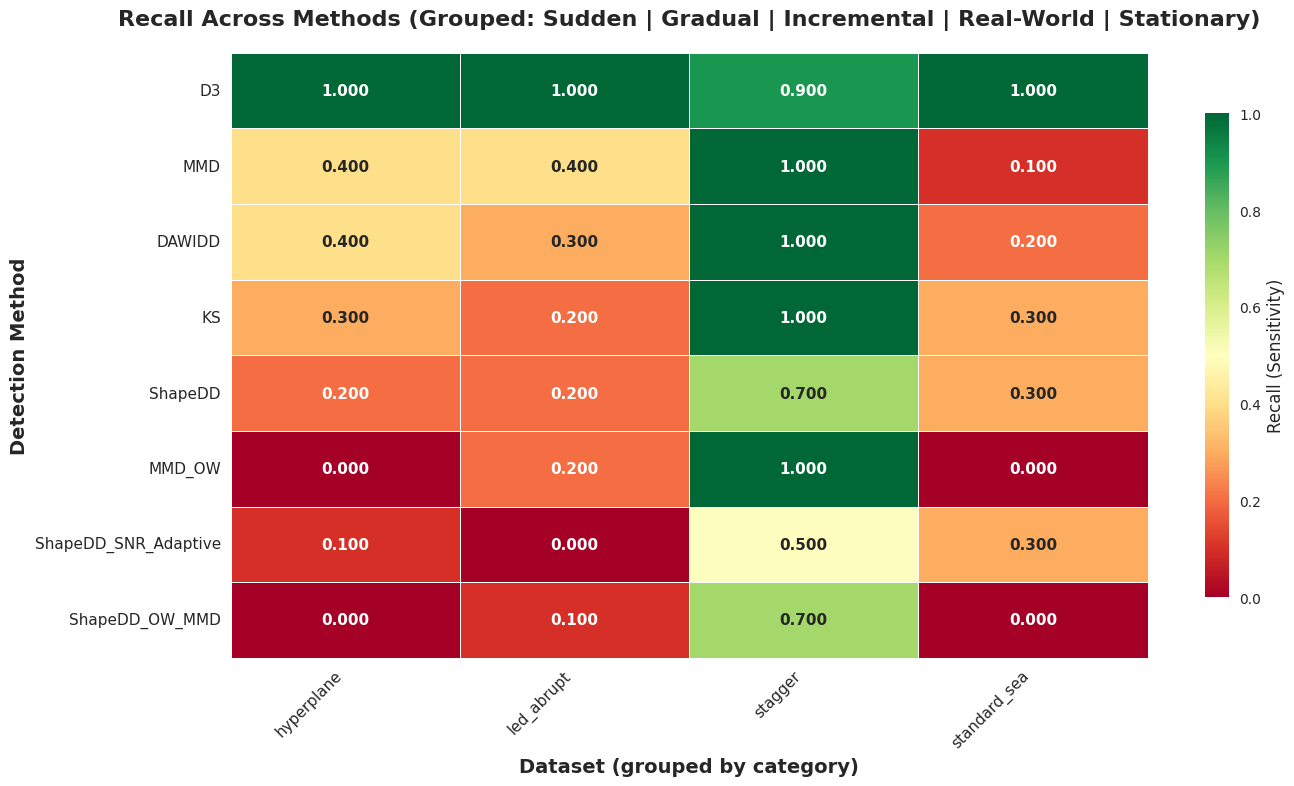

Figure 3 complete (4 datasets grouped by category)



In [19]:
# ============================================================================
# SECTION 17: PUBLICATION FIGURE 3 - Recall Heatmap
# ============================================================================

print("Generating Figure 3: Recall Heatmap (sorted by category)...")

# Only use datasets that are actually in the results
recall_pivot = results_df.pivot_table(values='Recall', index='Method', columns='Dataset', aggfunc='mean')

if len(recall_pivot.columns) == 0:
    print("⚠ No datasets with results found")
else:
    # Sort methods by average recall
    recall_pivot['_avg'] = recall_pivot.mean(axis=1)
    recall_pivot = recall_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
    
    # Sort datasets by category
    def categorize_drift_type(dataset_name):
        gradual_keywords = ['gradual', 'circles']
        incremental_keywords = ['rbf']
        stationary_keywords = ['none']
        dataset_lower = dataset_name.lower()
        if any(k in dataset_lower for k in stationary_keywords):
            return 'E_Stationary'
        elif any(k in dataset_lower for k in gradual_keywords):
            return 'B_Gradual'
        elif any(k in dataset_lower for k in incremental_keywords):
            return 'C_Incremental'
        elif 'electricity' in dataset_lower:
            return 'D_Real-World'
        else:
            return 'A_Sudden'
    
    # Only categorize datasets that exist in the pivot table
    dataset_categories = {col: categorize_drift_type(col) for col in recall_pivot.columns}
    sorted_columns = sorted(recall_pivot.columns, key=lambda x: (dataset_categories[x], x))
    recall_pivot = recall_pivot[sorted_columns]

    fig, ax = plt.subplots(figsize=(max(14, len(sorted_columns) * 1.2), max(8, len(recall_pivot) * 0.6)))
    sns.heatmap(recall_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                cbar_kws={'label': 'Recall (Sensitivity)', 'shrink': 0.8, 'aspect': 20},
                linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)

    ax.set_title('Recall Across Methods (Grouped: Sudden | Gradual | Incremental | Real-World | Stationary)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset (grouped by category)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Detection Method', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Add vertical lines to separate categories (only if multiple categories exist)
    unique_categories = set(dataset_categories.values())
    if len(unique_categories) > 1:
        prev_cat = None
        for idx, col in enumerate(recall_pivot.columns):
            cat = dataset_categories[col]
            if prev_cat is not None and cat != prev_cat:
                ax.axvline(x=idx, color='black', linewidth=2, linestyle='--', alpha=0.5)
            prev_cat = cat

    plt.tight_layout()

    for fmt in ['png', 'pdf']:
        filepath = output_dir / f"figure_3_recall_heatmap.{fmt}"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
        print(f"✓ Saved: {filepath}")

    plt.show()
    print(f"Figure 3 complete ({len(sorted_columns)} datasets grouped by category)\n")


Generating Figure 4: MTTD Heatmap (sorted by category)...
✓ Saved: publication_figures/figure_4_mttd_heatmap.png
✓ Saved: publication_figures/figure_4_mttd_heatmap.pdf


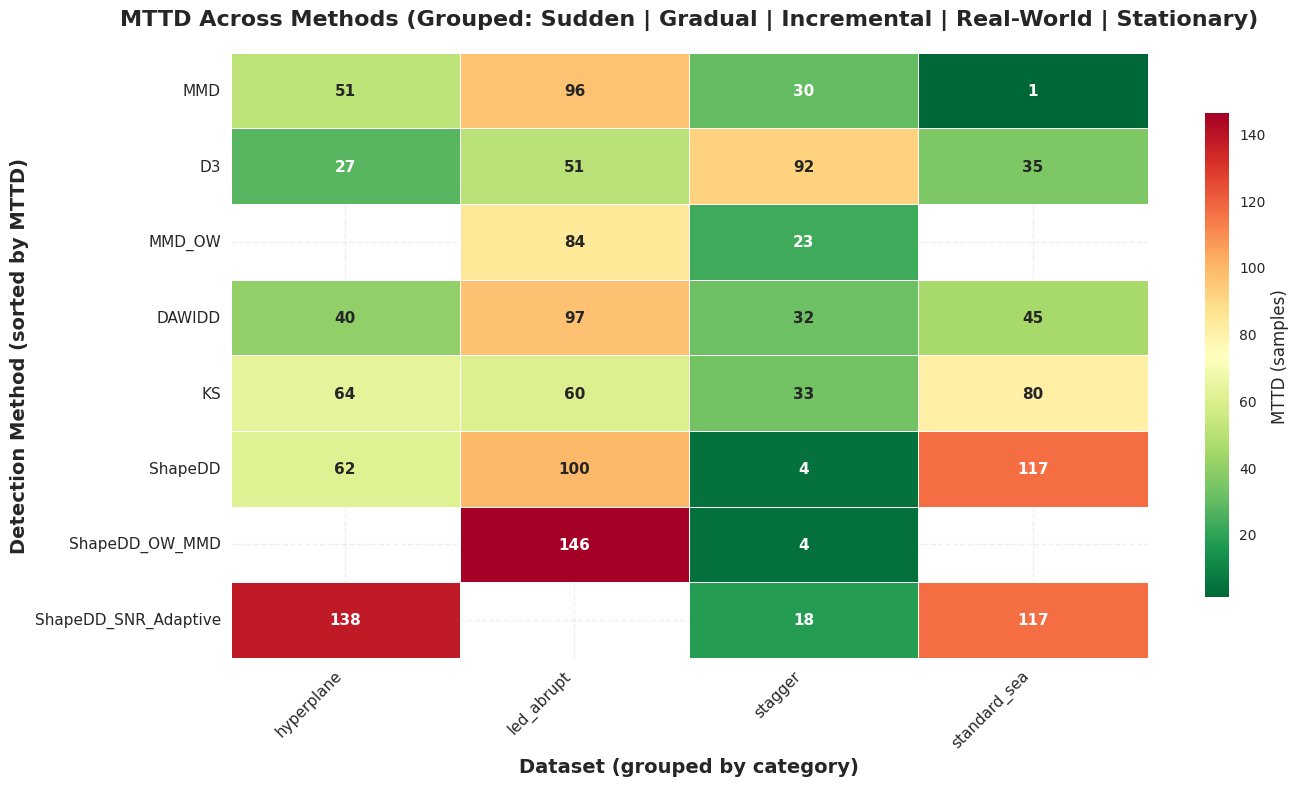

Figure 4 complete (4 datasets grouped by category)



In [20]:
# ============================================================================
# SECTION 18: PUBLICATION FIGURE 4 - MTTD Heatmap
# ============================================================================

print("Generating Figure 4: MTTD Heatmap (sorted by category)...")

# Only use datasets that are actually in the results
mttd_pivot = results_df.pivot_table(values='MTTD', index='Method', columns='Dataset', aggfunc='mean')

if len(mttd_pivot.columns) == 0:
    print("⚠ No datasets with results found")
else:
    # Sort methods by average MTTD (ascending - lower is better)
    mttd_pivot['_avg'] = mttd_pivot.mean(axis=1)
    mttd_pivot = mttd_pivot.sort_values('_avg', ascending=True).drop('_avg', axis=1)
    
    # Sort datasets by category
    def categorize_drift_type(dataset_name):
        gradual_keywords = ['gradual', 'circles']
        incremental_keywords = ['rbf']
        stationary_keywords = ['none']
        dataset_lower = dataset_name.lower()
        if any(k in dataset_lower for k in stationary_keywords):
            return 'E_Stationary'
        elif any(k in dataset_lower for k in gradual_keywords):
            return 'B_Gradual'
        elif any(k in dataset_lower for k in incremental_keywords):
            return 'C_Incremental'
        elif 'electricity' in dataset_lower:
            return 'D_Real-World'
        else:
            return 'A_Sudden'
    
    # Only categorize datasets that exist in the pivot table
    dataset_categories = {col: categorize_drift_type(col) for col in mttd_pivot.columns}
    sorted_columns = sorted(mttd_pivot.columns, key=lambda x: (dataset_categories[x], x))
    mttd_pivot = mttd_pivot[sorted_columns]

    fig, ax = plt.subplots(figsize=(max(14, len(sorted_columns) * 1.2), max(8, len(mttd_pivot) * 0.6)))
    sns.heatmap(mttd_pivot, annot=True, fmt='.0f', cmap='RdYlGn_r',
                cbar_kws={'label': 'MTTD (samples)', 'shrink': 0.8, 'aspect': 20},
                linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)

    ax.set_title('MTTD Across Methods (Grouped: Sudden | Gradual | Incremental | Real-World | Stationary)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset (grouped by category)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Detection Method (sorted by MTTD)', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Add vertical lines to separate categories (only if multiple categories exist)
    unique_categories = set(dataset_categories.values())
    if len(unique_categories) > 1:
        prev_cat = None
        for idx, col in enumerate(mttd_pivot.columns):
            cat = dataset_categories[col]
            if prev_cat is not None and cat != prev_cat:
                ax.axvline(x=idx, color='black', linewidth=2, linestyle='--', alpha=0.5)
            prev_cat = cat

    plt.tight_layout()

    for fmt in ['png', 'pdf']:
        filepath = output_dir / f"figure_4_mttd_heatmap.{fmt}"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
        print(f"✓ Saved: {filepath}")

    plt.show()
    print(f"Figure 4 complete ({len(sorted_columns)} datasets grouped by category)\n")


Generating Figure 5: Method Comparison Bar Chart...
✓ Saved: publication_figures/figure_5_method_comparison.png
✓ Saved: publication_figures/figure_5_method_comparison.pdf


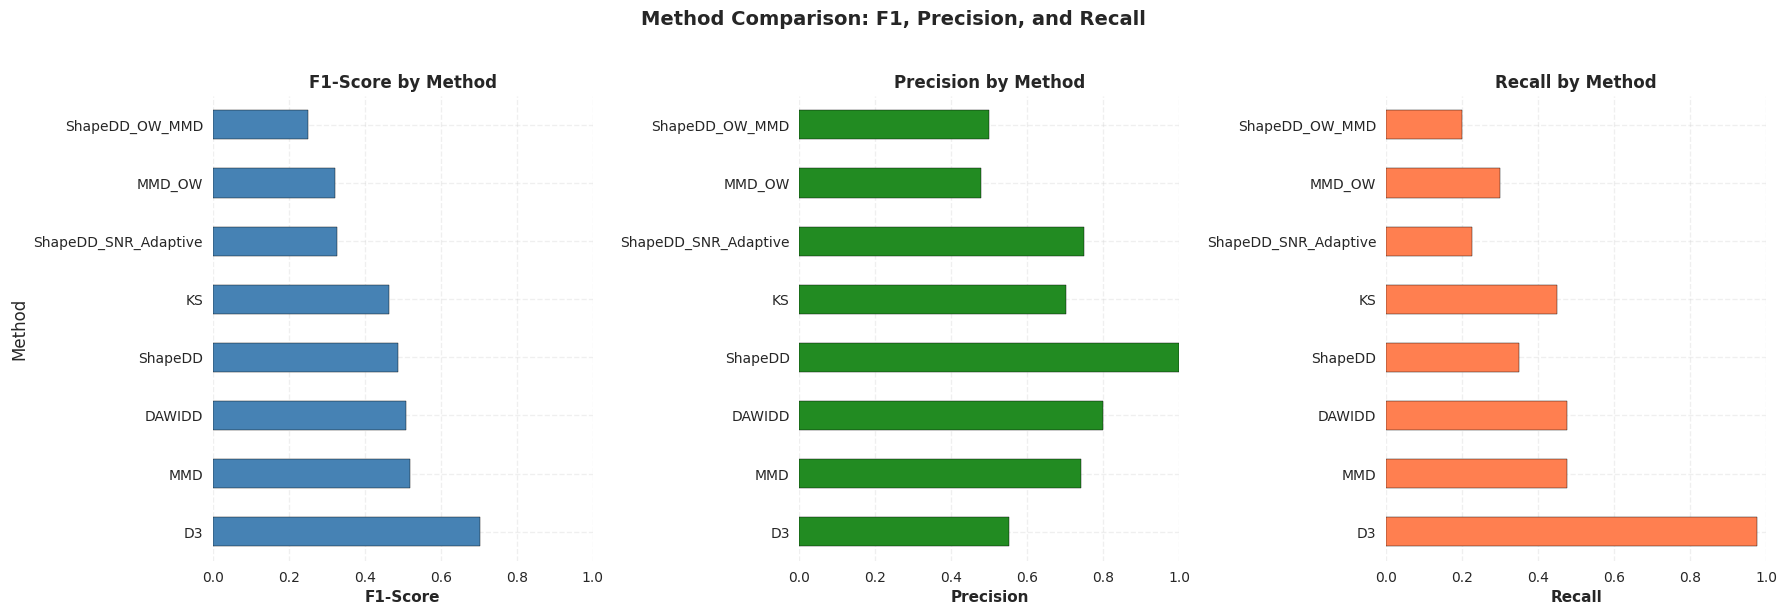

Figure 5 complete (8 methods)



In [21]:
# ============================================================================
# SECTION 19: PUBLICATION FIGURE 5 - Method Comparison
# ============================================================================
print("Generating Figure 5: Method Comparison Bar Chart...")

# Only use datasets with drift (N_Drifts > 0)
drift_results = results_df[results_df['N_Drifts'] > 0].copy()

method_summary = drift_results.groupby('Method').agg({
    'F1': 'mean',
    'Precision': 'mean',
    'Recall': 'mean'
}).round(3).sort_values('F1', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

method_summary['F1'].plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('F1-Score', fontsize=11, fontweight='bold')
axes[0].set_title('F1-Score by Method', fontsize=12, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

method_summary['Precision'].plot(kind='barh', ax=axes[1], color='forestgreen', edgecolor='black')
axes[1].set_xlabel('Precision', fontsize=11, fontweight='bold')
axes[1].set_title('Precision by Method', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

method_summary['Recall'].plot(kind='barh', ax=axes[2], color='coral', edgecolor='black')
axes[2].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[2].set_title('Recall by Method', fontsize=12, fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].set_ylabel('')
axes[2].grid(axis='x', alpha=0.3)

plt.suptitle('Method Comparison: F1, Precision, and Recall',
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

for fmt in ['png', 'pdf']:
    filepath = output_dir / f"figure_5_method_comparison.{fmt}"
    plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
    print(f"✓ Saved: {filepath}")

plt.show()
print(f"Figure 5 complete ({len(method_summary)} methods)\n")
